# Análisis de Satisfacción del Cliente - TechnoServe Solutions
## Factor Analysis Business Case

**Autores:** Marcos Saade & Gabriel Masri  
**Empresa:** TechnoServe Solutions - Firma de consultoría tecnológica  
**Dataset:** 3,400 respuestas de encuestas de 850 clientes empresariales  
**Período:** Q1-Q4 2024

In [56]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# PARTE 1: Exploración de Datos y Evaluación de Idoneidad

## 1.1 Exploración Básica de Datos


In [57]:
# Carga del dataset
df = pd.read_csv('customer_satisfaction_data.csv')

print("="*80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*80)
print(f"\nDimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"Período: {df['quarter'].unique()}")
print(f"Clientes únicos: {df['customer_id'].nunique()}")
print(f"Respuestas por cliente (promedio): {df.shape[0] / df['customer_id'].nunique():.1f}")

print("\n" + "="*80)
print("ESTRUCTURA DEL DATASET")
print("="*80)
df.info()

INFORMACIÓN GENERAL DEL DATASET

Dimensiones: 3400 filas × 31 columnas
Período: ['Q1_2024' 'Q2_2024' 'Q3_2024' 'Q4_2024']
Clientes únicos: 850
Respuestas por cliente (promedio): 4.0

ESTRUCTURA DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 3400 non-null   object 
 1   quarter                     3400 non-null   object 
 2   survey_date                 3400 non-null   object 
 3   account_manager_responsive  3384 non-null   float64
 4   billing_accuracy            3387 non-null   float64
 5   budget_control              3383 non-null   float64
 6   change_management           3388 non-null   float64
 7   communication_clarity       3384 non-null   float64
 8   competitive_pricing         3385 non-null   float64
 9   cost_transparency           3390 non-null   float64
 10

In [58]:
# Vista previa del dataset
df.head()

,customer_id,quarter,survey_date,account_manager_responsive,billing_accuracy,budget_control,change_management,communication_clarity,competitive_pricing,cost_transparency,documentation_help,executive_access,innovation_solutions,long_term_partnership,problem_solving,project_management,quality_deliverables,roi_demonstration,support_responsiveness,system_integration,technical_documentation,technical_expertise,timeline_adherence,training_quality,trust_reliability,value_for_money,overall_satisfaction,nps_score,renewal_likelihood,revenue_growth_pct,referrals_generated
0,CUST_001,Q1_2024,2024-03-22,5.000,6.000,4.000,5.000,4.000,5.000,5.000,5.000,5.000,4.000,5.000,5.000,4.000,5.000,5.000,4.000,5.000,5.000,4.000,4.000,2.000,6.000,6.000,4,6,4,12.300,1
1,CUST_002,Q1_2024,2024-03-20,5.000,3.000,4.000,5.000,5.000,3.000,3.000,3.000,5.000,4.000,6.000,3.000,4.000,4.000,4.000,3.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4,5,3,17.800,0
2,CUST_003,Q1_2024,2024-03-17,4.000,3.000,4.000,3.000,4.000,4.000,3.000,4.000,3.000,3.000,5.000,3.000,4.000,3.000,4.000,3.000,3.000,4.000,4.000,4.000,3.000,4.000,3.000,3,4,3,-7.800,0
3,CUST_004,Q1_2024,2024-03-08,3.000,4.000,4.000,3.000,2.000,3.000,4.000,3.000,3.000,4.000,3.000,4.000,4.000,3.000,3.000,2.000,3.000,3.000,4.000,4.000,4.000,2.000,4.000,4,5,2,-13.400,0
4,CUST_005,Q1_2024,2024-03-12,5.000,5.000,5.000,4.000,5.000,4.000,3.000,4.000,5.000,4.000,5.000,5.000,4.000,6.000,4.000,5.000,5.000,5.000,6.000,5.000,4.000,5.000,4.000,5,5,4,3.700,2


In [59]:
# Identificación de variables para análisis factorial

# Variables de satisfacción (23 items en escala Likert 1-7)
satisfaction_vars = [
    # Technical Excellence & Innovation (5 variables)
    'technical_expertise', 'problem_solving', 'innovation_solutions', 
    'technical_documentation', 'system_integration',
    
    # Relationship Management & Communication (5 variables)
    'account_manager_responsive', 'executive_access', 'trust_reliability',
    'long_term_partnership', 'communication_clarity',
    
    # Project Delivery & Quality (5 variables)
    'project_management', 'timeline_adherence', 'budget_control',
    'quality_deliverables', 'change_management',
    
    # Value & Financial Transparency (5 variables)
    'cost_transparency', 'value_for_money', 'roi_demonstration',
    'competitive_pricing', 'billing_accuracy',
    
    # Support & Service Excellence (3 variables)
    'support_responsiveness', 'training_quality', 'documentation_help'
]

# Variables de resultado
outcome_vars = ['overall_satisfaction', 'nps_score', 'renewal_likelihood', 
                'revenue_growth_pct', 'referrals_generated']

print(f"Variables de satisfacción: {len(satisfaction_vars)}")
print(f"Variables de resultado: {len(outcome_vars)}")

Variables de satisfacción: 23
Variables de resultado: 5


In [60]:
# Análisis de datos faltantes
print("="*80)
print("ANÁLISIS DE DATOS FALTANTES")
print("="*80)

missing_data = df[satisfaction_vars].isnull().sum()
missing_pct = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

print(f"\nTotal de observaciones: {len(df)}")
print(f"Variables con datos faltantes: {(missing_summary['Missing_Count'] > 0).sum()}")
print(f"Tasa promedio de datos faltantes: {missing_pct.mean():.2f}%")

if missing_pct.max() > 0:
    print(f"\nVariables con mayor porcentaje de datos faltantes:")
    print(missing_summary[missing_summary['Missing_Count'] > 0].head(10))
else:
    print("\nNo hay datos faltantes en las variables de satisfacción")

ANÁLISIS DE DATOS FALTANTES

Total de observaciones: 3400
Variables con datos faltantes: 23
Tasa promedio de datos faltantes: 0.43%

Variables con mayor porcentaje de datos faltantes:
                            Missing_Count  Missing_Percentage
trust_reliability                      22               0.647
problem_solving                        20               0.588
technical_documentation                19               0.559
roi_demonstration                      17               0.500
budget_control                         17               0.500
project_management                     17               0.500
support_responsiveness                 17               0.500
training_quality                       17               0.500
account_manager_responsive             16               0.471
communication_clarity                  16               0.471


In [61]:
# Estadísticas descriptivas
print("="*80)
print("ESTADÍSTICAS DESCRIPTIVAS - Variables de Satisfacción")
print("="*80)
print("\nEscala: 1 = Muy Insatisfecho, 4 = Neutral, 7 = Muy Satisfecho\n")

descriptive_stats = df[satisfaction_vars].describe().T
descriptive_stats['range'] = descriptive_stats['max'] - descriptive_stats['min']

print(descriptive_stats[['mean', 'std', 'min', 'max', 'range']].round(3))

ESTADÍSTICAS DESCRIPTIVAS - Variables de Satisfacción

Escala: 1 = Muy Insatisfecho, 4 = Neutral, 7 = Muy Satisfecho

                            mean   std   min   max  range
technical_expertise        4.115 0.975 1.000 7.000  6.000
problem_solving            4.111 0.991 1.000 7.000  6.000
innovation_solutions       4.105 0.985 1.000 7.000  6.000
technical_documentation    4.117 0.984 1.000 7.000  6.000
system_integration         4.113 1.005 1.000 7.000  6.000
account_manager_responsive 4.115 0.970 1.000 7.000  6.000
executive_access           4.114 0.969 1.000 7.000  6.000
trust_reliability          4.100 0.961 1.000 7.000  6.000
long_term_partnership      4.105 0.970 1.000 7.000  6.000
communication_clarity      4.092 0.965 1.000 7.000  6.000
project_management         4.114 0.980 1.000 7.000  6.000
timeline_adherence         4.111 0.981 1.000 7.000  6.000
budget_control             4.101 0.983 1.000 7.000  6.000
quality_deliverables       4.131 0.982 1.000 7.000  6.000
change_manag

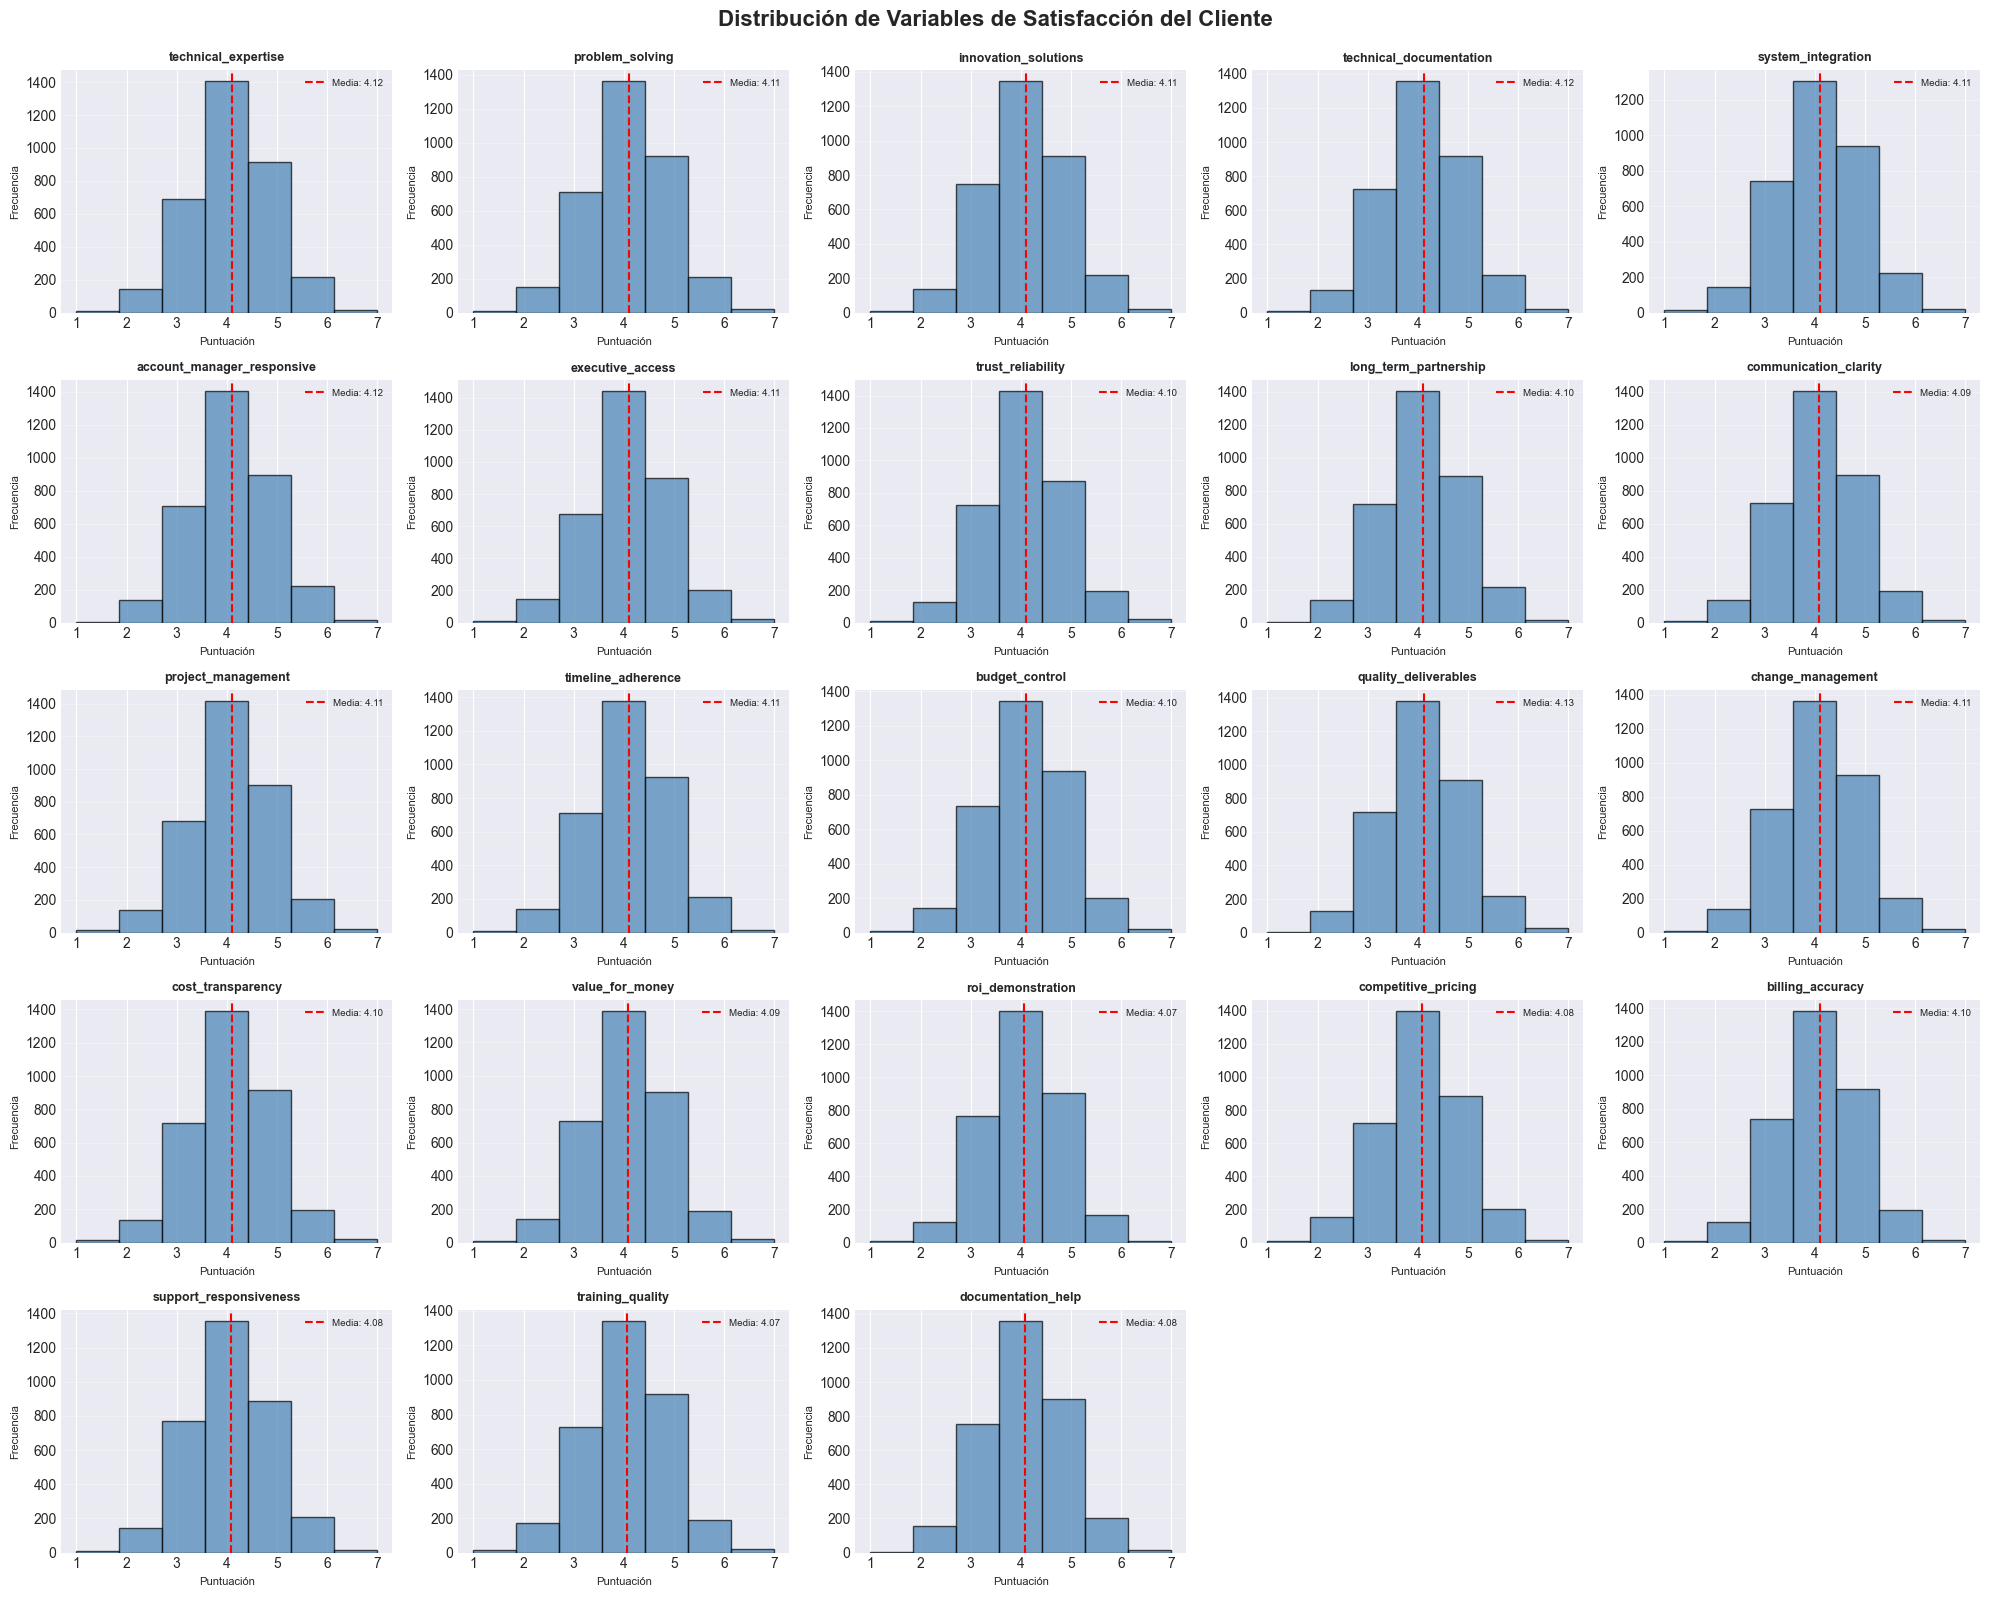

In [62]:
# Distribuciones de las variables de satisfacción
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
axes = axes.ravel()

for idx, var in enumerate(satisfaction_vars):
    axes[idx].hist(df[var].dropna(), bins=7, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f'{var}', fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('Puntuación', fontsize=8)
    axes[idx].set_ylabel('Frecuencia', fontsize=8)
    axes[idx].axvline(df[var].mean(), color='red', linestyle='--', linewidth=1.5, label=f'Media: {df[var].mean():.2f}')
    axes[idx].legend(fontsize=7)
    axes[idx].grid(axis='y', alpha=0.3)

for idx in range(len(satisfaction_vars), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribución de Variables de Satisfacción del Cliente', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

MATRIZ DE CORRELACIÓN


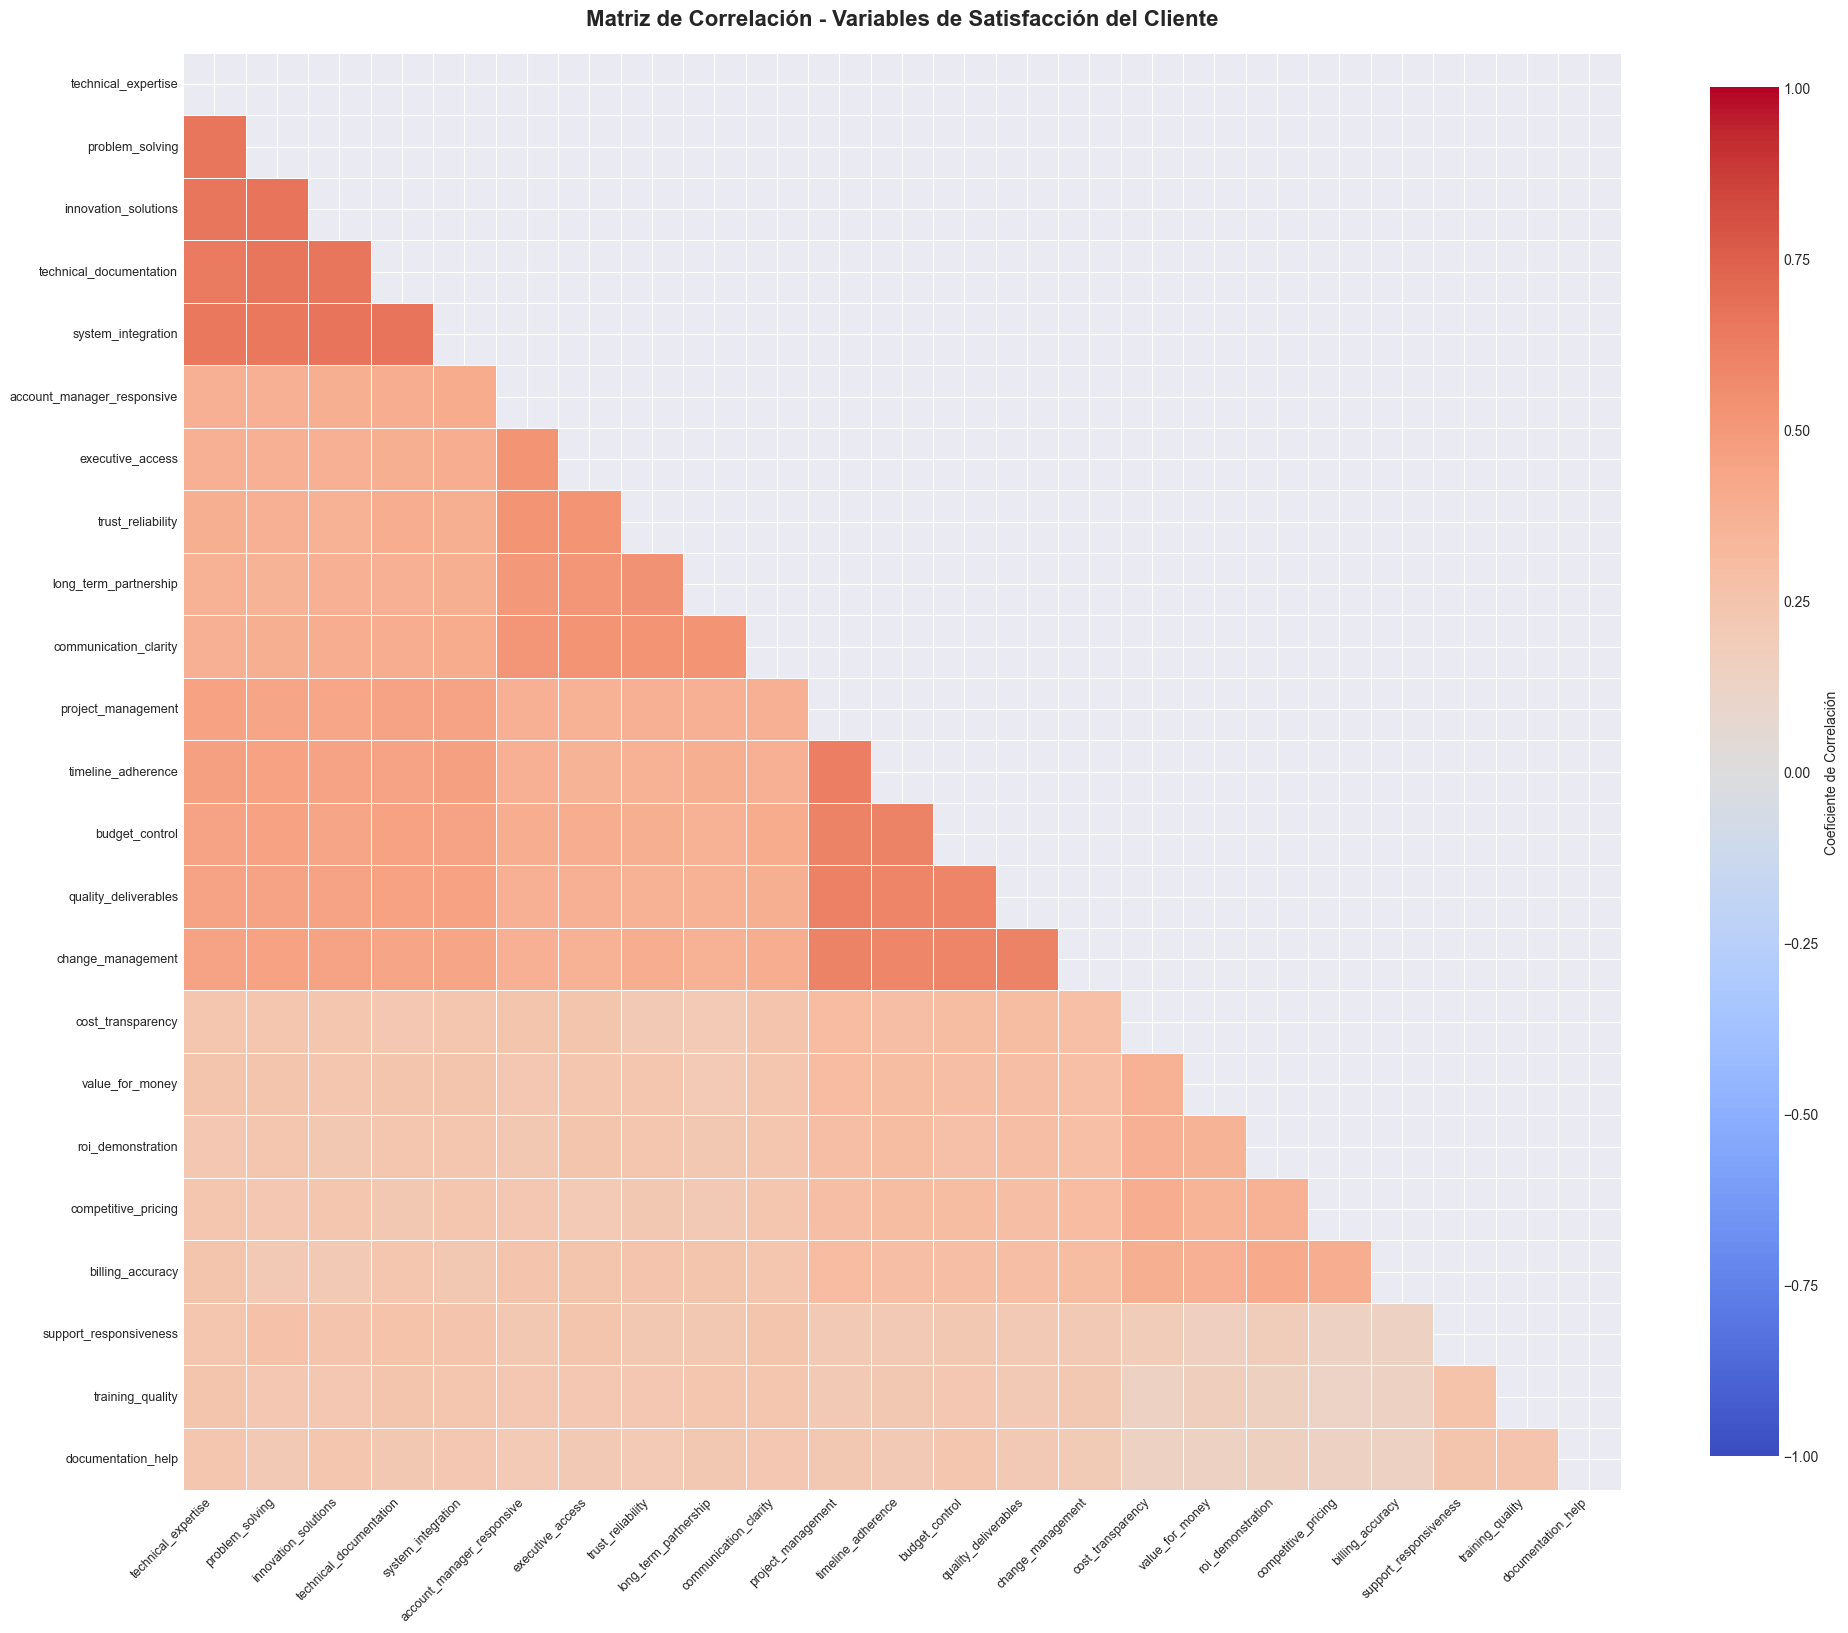


Correlación promedio: 0.334
Correlación máxima: 0.671
Correlación mínima: 0.129
Correlaciones |r| ≥ 0.3: 122/253 (48.2%)


In [63]:
# Matriz de Correlación
correlation_matrix = df[satisfaction_vars].corr()

print("="*80)
print("MATRIZ DE CORRELACIÓN")
print("="*80)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlación"})

plt.title('Matriz de Correlación - Variables de Satisfacción del Cliente', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# Análisis de correlaciones
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
high_corr = np.sum(np.abs(corr_values) >= 0.3)
total_corr = len(corr_values)
pct_high_corr = (high_corr / total_corr) * 100

print(f"\nCorrelación promedio: {corr_values.mean():.3f}")
print(f"Correlación máxima: {corr_values.max():.3f}")
print(f"Correlación mínima: {corr_values.min():.3f}")
print(f"Correlaciones |r| ≥ 0.3: {high_corr}/{total_corr} ({pct_high_corr:.1f}%)")

## 1.2 Evaluación de Idoneidad para Análisis Factorial

Pruebas estadísticas para verificar si los datos son apropiados para factor analysis.


In [64]:
# Preparación de datos
df_clean = df[satisfaction_vars].dropna()

print("="*80)
print("PREPARACIÓN DE DATOS")
print("="*80)
print(f"\nDatos originales: {len(df)} observaciones")
print(f"Datos limpios: {len(df_clean)} observaciones")
print(f"Observaciones eliminadas: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df)*100):.2f}%)")
print(f"\nVariables: {df_clean.shape[1]}")
print(f"Observaciones: {df_clean.shape[0]}")
print(f"Ratio observaciones/variables: {df_clean.shape[0]/df_clean.shape[1]:.1f}:1")

PREPARACIÓN DE DATOS

Datos originales: 3400 observaciones
Datos limpios: 3235 observaciones
Observaciones eliminadas: 165 (4.85%)

Variables: 23
Observaciones: 3235
Ratio observaciones/variables: 140.7:1


In [65]:
# Test KMO (Kaiser-Meyer-Olkin)
print("="*80)
print("TEST KMO (KAISER-MEYER-OLKIN)")
print("="*80)

kmo_all, kmo_model = calculate_kmo(df_clean)

print(f"\nKMO General del Modelo: {kmo_model:.4f}")

# Interpretación
if kmo_model >= 0.9:
    interpretation = "EXCELENTE"
elif kmo_model >= 0.8:
    interpretation = "MUY BUENO"
elif kmo_model >= 0.7:
    interpretation = "BUENO"
elif kmo_model >= 0.6:
    interpretation = "ACEPTABLE"
else:
    interpretation = "INACEPTABLE"

print(f"Interpretación: {interpretation}")
print(f"Conclusión: Los datos son {'APTOS' if kmo_model >= 0.6 else 'NO APTOS'} para análisis factorial")

# KMO por variable
kmo_df = pd.DataFrame({
    'Variable': satisfaction_vars,
    'KMO': kmo_all
}).sort_values('KMO', ascending=False)

print(f"\nVariables con KMO ≥ 0.5: {(kmo_df['KMO'] >= 0.5).sum()}/{len(kmo_df)}")
print(f"Variables con KMO < 0.5: {(kmo_df['KMO'] < 0.5).sum()}/{len(kmo_df)}")

print("\nTop 10 variables (KMO más alto):")
print(kmo_df.head(10).to_string(index=False))

print("\nBottom 5 variables (KMO más bajo):")
print(kmo_df.tail(5).to_string(index=False))

TEST KMO (KAISER-MEYER-OLKIN)

KMO General del Modelo: 0.9593
Interpretación: EXCELENTE
Conclusión: Los datos son APTOS para análisis factorial

Variables con KMO ≥ 0.5: 23/23
Variables con KMO < 0.5: 0/23

Top 10 variables (KMO más alto):
                  Variable   KMO
            budget_control 0.967
         change_management 0.966
      quality_deliverables 0.966
        timeline_adherence 0.965
account_manager_responsive 0.965
     communication_clarity 0.963
        project_management 0.962
       technical_expertise 0.962
   technical_documentation 0.962
        system_integration 0.961

Bottom 5 variables (KMO más bajo):
           Variable   KMO
    value_for_money 0.952
  roi_demonstration 0.942
  cost_transparency 0.942
competitive_pricing 0.941
   billing_accuracy 0.933


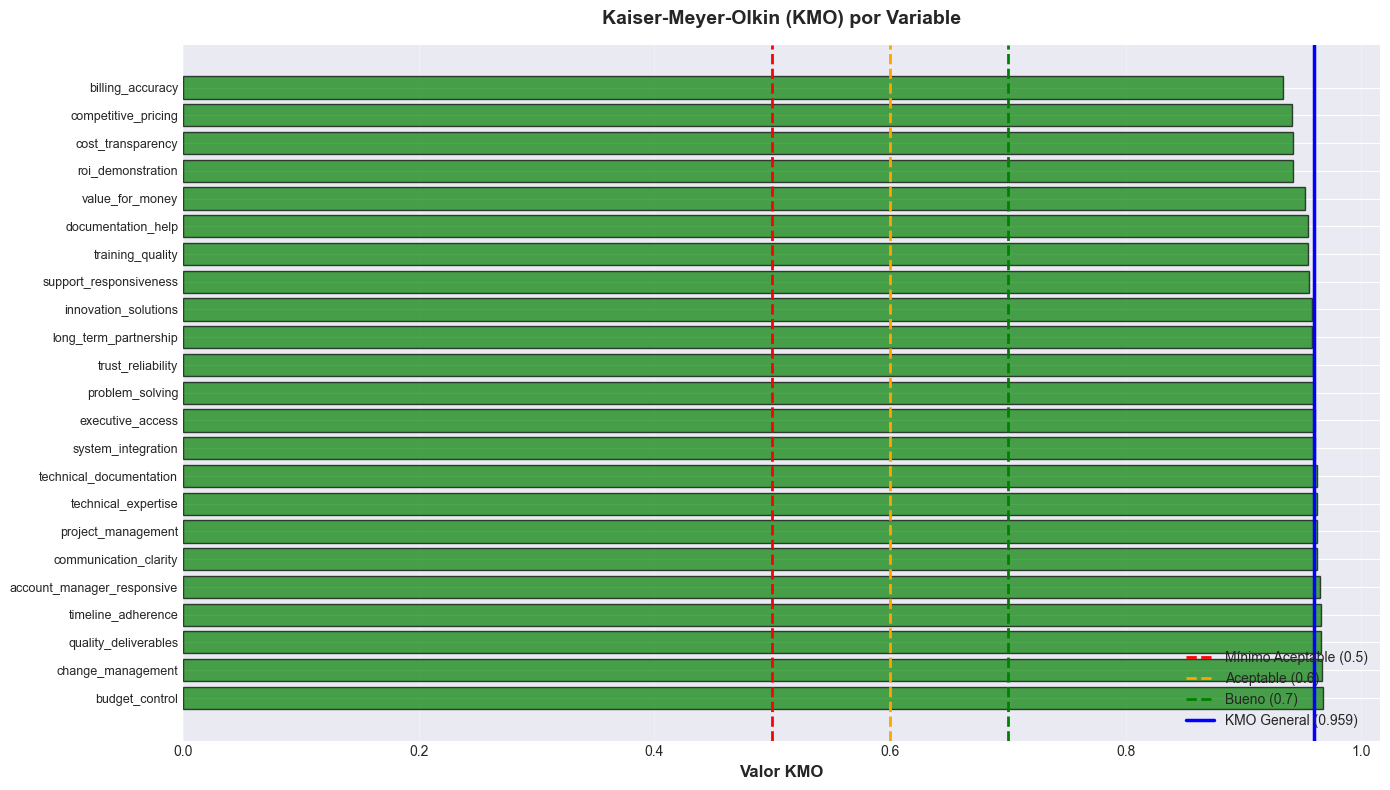

In [66]:
# Visualización KMO por variable
plt.figure(figsize=(14, 8))
colors = ['green' if x >= 0.7 else 'orange' if x >= 0.6 else 'red' for x in kmo_df['KMO']]
bars = plt.barh(range(len(kmo_df)), kmo_df['KMO'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(range(len(kmo_df)), kmo_df['Variable'], fontsize=9)
plt.xlabel('Valor KMO', fontsize=12, fontweight='bold')
plt.title('Kaiser-Meyer-Olkin (KMO) por Variable', 
          fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Mínimo Aceptable (0.5)')
plt.axvline(x=0.6, color='orange', linestyle='--', linewidth=2, label='Aceptable (0.6)')
plt.axvline(x=0.7, color='green', linestyle='--', linewidth=2, label='Bueno (0.7)')
plt.axvline(x=kmo_model, color='blue', linestyle='-', linewidth=2.5, label=f'KMO General ({kmo_model:.3f})')
plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
# Test de Esfericidad de Bartlett
print("="*80)
print("TEST DE ESFERICIDAD DE BARTLETT")
print("="*80)

chi_square_value, p_value = calculate_bartlett_sphericity(df_clean)

print(f"\nEstadístico Chi-cuadrado: {chi_square_value:.2f}")
print(f"Grados de libertad: {len(satisfaction_vars) * (len(satisfaction_vars) - 1) // 2}")
print(f"Valor p: {p_value:.2e}")

print("\nInterpretación:")
print("H0: Matriz de correlación = Matriz identidad (variables no correlacionadas)")
print("H1: Matriz de correlación ≠ Matriz identidad (variables correlacionadas)")

if p_value < 0.05:
    print(f"\nConclusión: RECHAZAMOS H0 (p < 0.05)")
    print("Las variables están significativamente correlacionadas")
    print("Los datos son APTOS para análisis factorial")
else:
    print(f"\nConclusión: NO RECHAZAMOS H0 (p ≥ 0.05)")
    print("Las variables NO están suficientemente correlacionadas")
    print("Los datos NO son aptos para análisis factorial")

TEST DE ESFERICIDAD DE BARTLETT

Estadístico Chi-cuadrado: 33163.38
Grados de libertad: 253
Valor p: 0.00e+00

Interpretación:
H0: Matriz de correlación = Matriz identidad (variables no correlacionadas)
H1: Matriz de correlación ≠ Matriz identidad (variables correlacionadas)

Conclusión: RECHAZAMOS H0 (p < 0.05)
Las variables están significativamente correlacionadas
Los datos son APTOS para análisis factorial


In [68]:
# Evaluación de correlaciones suficientes
print("="*80)
print("EVALUACIÓN DE ESTRUCTURA CORRELACIONAL")
print("="*80)

corr_matrix = df_clean.corr()
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]

high_corr = np.sum(np.abs(upper_triangle) >= 0.3)
moderate_corr = np.sum((np.abs(upper_triangle) >= 0.2) & (np.abs(upper_triangle) < 0.3))
low_corr = np.sum(np.abs(upper_triangle) < 0.2)
total_corr = len(upper_triangle)

pct_high = (high_corr / total_corr) * 100
pct_moderate = (moderate_corr / total_corr) * 100
pct_low = (low_corr / total_corr) * 100

print(f"\nTotal de correlaciones únicas: {total_corr}")
print(f"\nDistribución de correlaciones:")
print(f"  |r| ≥ 0.3 (altas):      {high_corr:4d} ({pct_high:5.1f}%)")
print(f"  0.2 ≤ |r| < 0.3 (moderadas): {moderate_corr:4d} ({pct_moderate:5.1f}%)")
print(f"  |r| < 0.2 (bajas):      {low_corr:4d} ({pct_low:5.1f}%)")

print(f"\nEstadísticas:")
print(f"  Promedio: {np.mean(upper_triangle):.3f}")
print(f"  Mediana:  {np.median(upper_triangle):.3f}")
print(f"  Máximo:   {np.max(upper_triangle):.3f}")
print(f"  Mínimo:   {np.min(upper_triangle):.3f}")

print(f"\nCriterio: >30% de correlaciones con |r| ≥ 0.3")
print(f"Resultado: {pct_high:.1f}% - {'CUMPLE' if pct_high > 30 else 'NO CUMPLE'}")

EVALUACIÓN DE ESTRUCTURA CORRELACIONAL

Total de correlaciones únicas: 253

Distribución de correlaciones:
  |r| ≥ 0.3 (altas):       122 ( 48.2%)
  0.2 ≤ |r| < 0.3 (moderadas):  115 ( 45.5%)
  |r| < 0.2 (bajas):        16 (  6.3%)

Estadísticas:
  Promedio: 0.337
  Mediana:  0.296
  Máximo:   0.674
  Mínimo:   0.127

Criterio: >30% de correlaciones con |r| ≥ 0.3
Resultado: 48.2% - CUMPLE


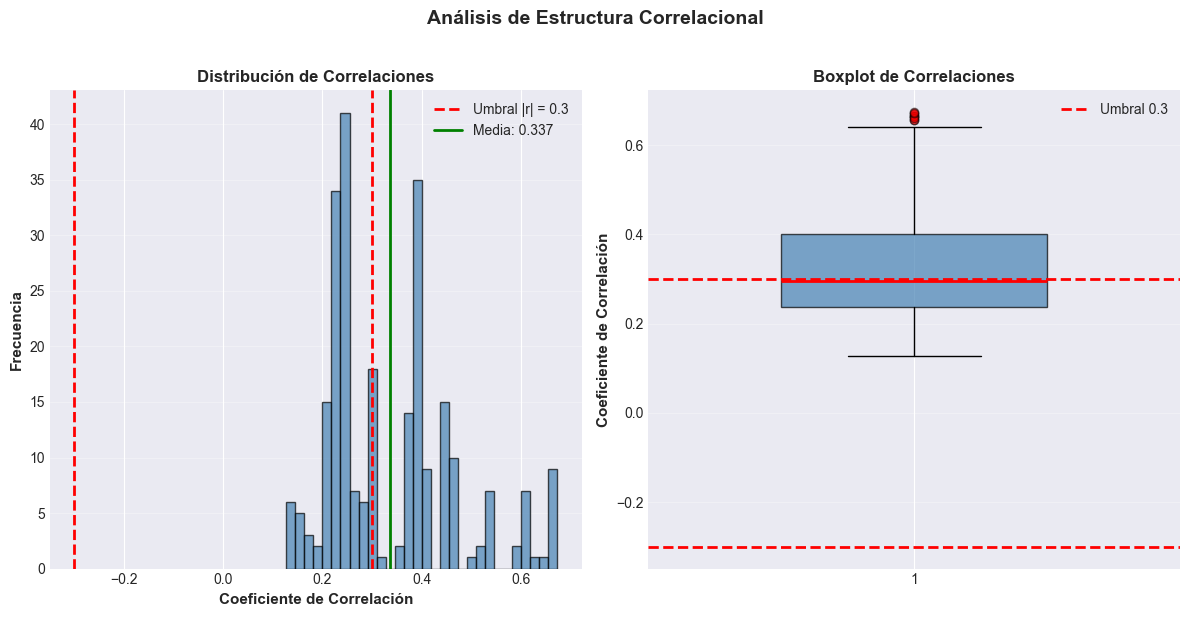

In [69]:
# Distribución de correlaciones
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(upper_triangle, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Umbral |r| = 0.3')
plt.axvline(x=-0.3, color='red', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(upper_triangle), color='green', linestyle='-', linewidth=2, label=f'Media: {np.mean(upper_triangle):.3f}')
plt.xlabel('Coeficiente de Correlación', fontsize=11, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=11, fontweight='bold')
plt.title('Distribución de Correlaciones', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
box = plt.boxplot(upper_triangle, vert=True, patch_artist=True, 
                   widths=0.5,
                   boxprops=dict(facecolor='steelblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
plt.ylabel('Coeficiente de Correlación', fontsize=11, fontweight='bold')
plt.title('Boxplot de Correlaciones', fontsize=12, fontweight='bold')
plt.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Umbral 0.3')
plt.axhline(y=-0.3, color='red', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.suptitle('Análisis de Estructura Correlacional', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [70]:
# Resumen de evaluación de idoneidad
print("\n" + "="*80)
print("RESUMEN: EVALUACIÓN DE IDONEIDAD PARA ANÁLISIS FACTORIAL")
print("="*80)

tests_results = {
    'Tamaño de muestra': {
        'Criterio': 'N > 300 y ratio N:variables > 10:1',
        'Resultado': f'N={len(df_clean)}, ratio={len(df_clean)/len(satisfaction_vars):.1f}:1',
        'Cumple': len(df_clean) > 300 and (len(df_clean)/len(satisfaction_vars)) > 10
    },
    'Test KMO': {
        'Criterio': 'KMO > 0.6',
        'Resultado': f'{kmo_model:.4f}',
        'Cumple': kmo_model > 0.6
    },
    'Test de Bartlett': {
        'Criterio': 'p < 0.05',
        'Resultado': f'{p_value:.2e}',
        'Cumple': p_value < 0.05
    },
    'Correlaciones': {
        'Criterio': '>30% con |r| ≥ 0.3',
        'Resultado': f'{pct_high:.1f}%',
        'Cumple': pct_high > 30
    }
}

print("\nCRITERIOS DE IDONEIDAD:\n")
for i, (test, info) in enumerate(tests_results.items(), 1):
    status = "CUMPLE" if info['Cumple'] else "NO CUMPLE"
    print(f"{i}. {test}")
    print(f"   Criterio: {info['Criterio']}")
    print(f"   Resultado: {info['Resultado']}")
    print(f"   {status}\n")

all_pass = all(info['Cumple'] for info in tests_results.values())

print("="*80)
print("DECISIÓN FINAL")
print("="*80)

if all_pass:
    print("\nDECISIÓN: Los datos SON APTOS para análisis factorial")
    print("\nJUSTIFICACIÓN:")
    print("  - Tamaño de muestra adecuado")
    print("  - KMO indica buena adecuación del muestreo")
    print("  - Test de Bartlett confirma correlaciones significativas")
    print("  - Suficiente estructura correlacional")
else:
    print("\nDECISIÓN: Los datos requieren revisión adicional")
    print("\nPROBLEMAS:")
    for test, info in tests_results.items():
        if not info['Cumple']:
            print(f"  - {test}: {info['Resultado']}")


RESUMEN: EVALUACIÓN DE IDONEIDAD PARA ANÁLISIS FACTORIAL

CRITERIOS DE IDONEIDAD:

1. Tamaño de muestra
   Criterio: N > 300 y ratio N:variables > 10:1
   Resultado: N=3235, ratio=140.7:1
   CUMPLE

2. Test KMO
   Criterio: KMO > 0.6
   Resultado: 0.9593
   CUMPLE

3. Test de Bartlett
   Criterio: p < 0.05
   Resultado: 0.00e+00
   CUMPLE

4. Correlaciones
   Criterio: >30% con |r| ≥ 0.3
   Resultado: 48.2%
   CUMPLE

DECISIÓN FINAL

DECISIÓN: Los datos SON APTOS para análisis factorial

JUSTIFICACIÓN:
  - Tamaño de muestra adecuado
  - KMO indica buena adecuación del muestreo
  - Test de Bartlett confirma correlaciones significativas
  - Suficiente estructura correlacional


# PARTE 2: Extracción y Determinación del Número de Factores

## 2.1 Determinación del Número de Factores


In [71]:
# Análisis inicial de eigenvalues
fa_initial = FactorAnalyzer(n_factors=len(satisfaction_vars), rotation=None)
fa_initial.fit(df_clean)

eigenvalues, _ = fa_initial.get_eigenvalues()

print("="*80)
print("ANÁLISIS DE EIGENVALUES")
print("="*80)

eigenvalues_df = pd.DataFrame({
    'Factor': range(1, len(eigenvalues) + 1),
    'Eigenvalue': eigenvalues,
    'Variance_Explained': (eigenvalues / eigenvalues.sum()) * 100,
    'Cumulative_Variance': np.cumsum((eigenvalues / eigenvalues.sum()) * 100)
})

print("\n", eigenvalues_df.head(10).to_string(index=False))

# Criterio de Kaiser (eigenvalues > 1)
n_factors_kaiser = (eigenvalues > 1).sum()
print(f"\nCriterio de Kaiser (eigenvalues > 1): {n_factors_kaiser} factores")
print(f"Varianza explicada con {n_factors_kaiser} factores: {eigenvalues_df.iloc[n_factors_kaiser-1]['Cumulative_Variance']:.2f}%")

ANÁLISIS DE EIGENVALUES

  Factor  Eigenvalue  Variance_Explained  Cumulative_Variance
      1       8.747              38.030               38.030
      2       1.776               7.720               45.750
      3       1.425               6.195               51.945
      4       1.204               5.235               57.180
      5       1.073               4.667               61.847
      6       0.762               3.313               65.159
      7       0.741               3.223               68.383
      8       0.650               2.825               71.207
      9       0.642               2.793               74.000
     10       0.607               2.640               76.640

Criterio de Kaiser (eigenvalues > 1): 5 factores
Varianza explicada con 5 factores: 61.85%


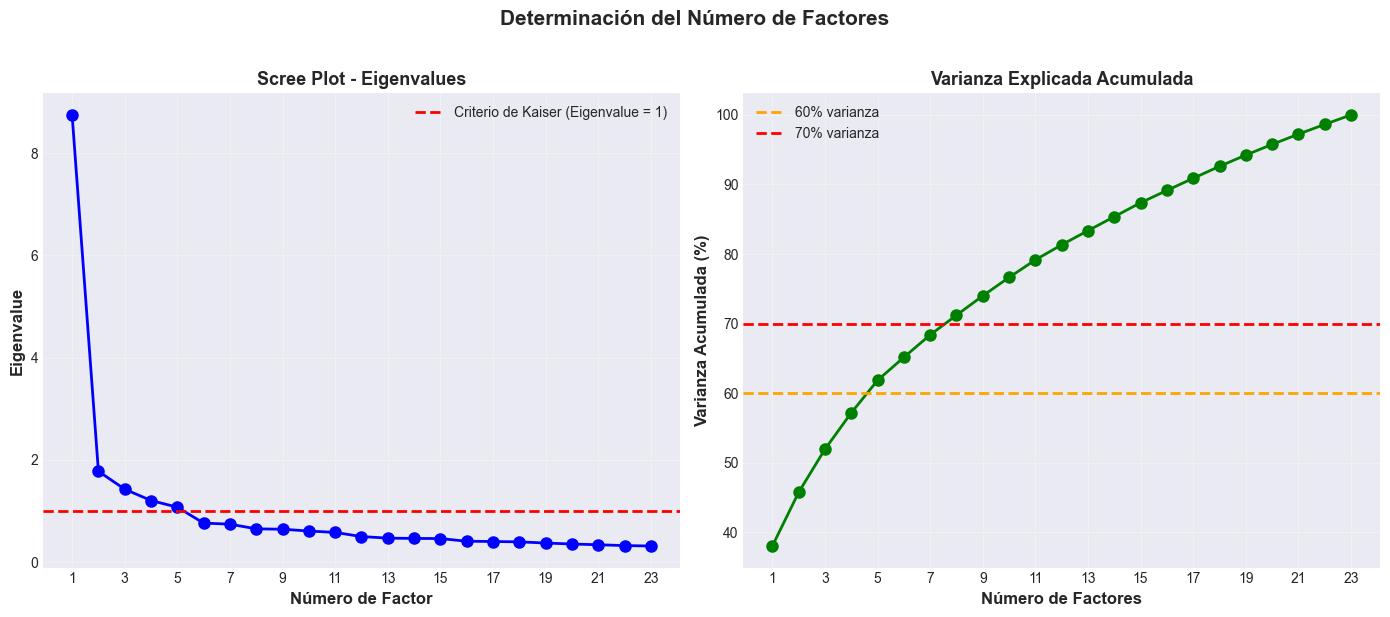

In [72]:
# Scree Plot
plt.figure(figsize=(14, 6))

# Scree plot de eigenvalues
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=1, color='r', linestyle='--', linewidth=2, label='Criterio de Kaiser (Eigenvalue = 1)')
plt.xlabel('Número de Factor', fontsize=12, fontweight='bold')
plt.ylabel('Eigenvalue', fontsize=12, fontweight='bold')
plt.title('Scree Plot - Eigenvalues', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, len(eigenvalues) + 1, 2))

# Varianza explicada acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues_df['Cumulative_Variance'], 'go-', linewidth=2, markersize=8)
plt.axhline(y=60, color='orange', linestyle='--', linewidth=2, label='60% varianza')
plt.axhline(y=70, color='red', linestyle='--', linewidth=2, label='70% varianza')
plt.xlabel('Número de Factores', fontsize=12, fontweight='bold')
plt.ylabel('Varianza Acumulada (%)', fontsize=12, fontweight='bold')
plt.title('Varianza Explicada Acumulada', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, len(eigenvalues) + 1, 2))

plt.suptitle('Determinación del Número de Factores', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [73]:
# Análisis de varianza explicada por diferentes números de factores
print("="*80)
print("COMPARACIÓN DE SOLUCIONES FACTORIALES")
print("="*80)

solutions_comparison = []

for n in range(3, 8):
    fa_temp = FactorAnalyzer(n_factors=n, rotation=None)
    fa_temp.fit(df_clean)
    variance = fa_temp.get_factor_variance()
    
    solutions_comparison.append({
        'n_factors': n,
        'proportional_var': variance[1][-1] * 100,
        'cumulative_var': variance[2][-1] * 100
    })

comparison_df = pd.DataFrame(solutions_comparison)
print("\n", comparison_df.to_string(index=False))

print("\n" + "="*80)
print("DECISIÓN SOBRE NÚMERO DE FACTORES")
print("="*80)
print(f"\nCriterio de Kaiser: {n_factors_kaiser} factores")
print(f"Scree Plot: Inspección visual sugiere búsqueda de 'codo' en la gráfica")
print(f"Varianza explicada: Evaluar soluciones con 60-70% de varianza acumulada")
print(f"\nSolución propuesta: {n_factors_kaiser} factores")
print(f"Justificación: Balance entre parsimonia y varianza explicada")

COMPARACIÓN DE SOLUCIONES FACTORIALES

  n_factors  proportional_var  cumulative_var
         3             4.138          45.341
         4             3.228          48.958
         5             1.677          50.711
         6             0.448          51.298
         7             0.262          51.647

DECISIÓN SOBRE NÚMERO DE FACTORES

Criterio de Kaiser: 5 factores
Scree Plot: Inspección visual sugiere búsqueda de 'codo' en la gráfica
Varianza explicada: Evaluar soluciones con 60-70% de varianza acumulada

Solución propuesta: 5 factores
Justificación: Balance entre parsimonia y varianza explicada

  n_factors  proportional_var  cumulative_var
         3             4.138          45.341
         4             3.228          48.958
         5             1.677          50.711
         6             0.448          51.298
         7             0.262          51.647

DECISIÓN SOBRE NÚMERO DE FACTORES

Criterio de Kaiser: 5 factores
Scree Plot: Inspección visual sugiere búsqueda d

## 2.2 Extracción de Factores y Rotación


In [74]:
# Extracción de factores sin rotación
print("="*80)
print("EXTRACCIÓN DE FACTORES - SIN ROTACIÓN")
print("="*80)

fa_no_rotation = FactorAnalyzer(n_factors=n_factors_kaiser, rotation=None)
fa_no_rotation.fit(df_clean)

loadings_no_rot = pd.DataFrame(
    fa_no_rotation.loadings_,
    index=satisfaction_vars,
    columns=[f'Factor_{i+1}' for i in range(n_factors_kaiser)]
)

print(f"\nMatriz de cargas factoriales ({n_factors_kaiser} factores, sin rotación):")
print(loadings_no_rot.round(3))

# Varianza explicada
variance_no_rot = fa_no_rotation.get_factor_variance()
variance_df_no_rot = pd.DataFrame({
    'Factor': [f'Factor_{i+1}' for i in range(n_factors_kaiser)],
    'SS_Loadings': variance_no_rot[0],
    'Proportion_Var': variance_no_rot[1],
    'Cumulative_Var': variance_no_rot[2]
})

print("\nVarianza explicada por factor:")
print(variance_df_no_rot.round(4))

EXTRACCIÓN DE FACTORES - SIN ROTACIÓN

Matriz de cargas factoriales (5 factores, sin rotación):
                            Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
technical_expertise            0.714    -0.293    -0.165     0.145    -0.037
problem_solving                0.716    -0.319    -0.173     0.143    -0.041
innovation_solutions           0.717    -0.327    -0.164     0.163    -0.034
technical_documentation        0.719    -0.308    -0.141     0.146    -0.039
system_integration             0.724    -0.314    -0.145     0.149    -0.050
account_manager_responsive     0.620    -0.004     0.348    -0.002    -0.083
executive_access               0.622     0.003     0.375     0.011    -0.064
trust_reliability              0.625    -0.004     0.383    -0.012    -0.087
long_term_partnership          0.609    -0.014     0.384    -0.020    -0.053
communication_clarity          0.631    -0.002     0.365    -0.001    -0.036
project_management             0.705     0.103    -0.144 

In [75]:
# Extracción de factores con rotación Varimax
print("\n" + "="*80)
print("EXTRACCIÓN DE FACTORES - CON ROTACIÓN VARIMAX")
print("="*80)

fa_varimax = FactorAnalyzer(n_factors=n_factors_kaiser, rotation='varimax')
fa_varimax.fit(df_clean)

loadings_varimax = pd.DataFrame(
    fa_varimax.loadings_,
    index=satisfaction_vars,
    columns=[f'Factor_{i+1}' for i in range(n_factors_kaiser)]
)

print(f"\nMatriz de cargas factoriales ({n_factors_kaiser} factores, rotación Varimax):")
print(loadings_varimax.round(3))

# Varianza explicada después de rotación
variance_varimax = fa_varimax.get_factor_variance()
variance_df_varimax = pd.DataFrame({
    'Factor': [f'Factor_{i+1}' for i in range(n_factors_kaiser)],
    'SS_Loadings': variance_varimax[0],
    'Proportion_Var': variance_varimax[1],
    'Cumulative_Var': variance_varimax[2]
})

print("\nVarianza explicada por factor (después de rotación):")
print(variance_df_varimax.round(4))


EXTRACCIÓN DE FACTORES - CON ROTACIÓN VARIMAX

Matriz de cargas factoriales (5 factores, rotación Varimax):
                            Factor_1  Factor_2  Factor_3  Factor_4  Factor_5
technical_expertise            0.693     0.219     0.246     0.166     0.171
problem_solving                0.714     0.215     0.247     0.149     0.167
innovation_solutions           0.722     0.220     0.228     0.149     0.179
technical_documentation        0.697     0.242     0.238     0.152     0.175
system_integration             0.709     0.245     0.238     0.153     0.166
account_manager_responsive     0.221     0.610     0.197     0.175     0.148
executive_access               0.209     0.628     0.181     0.178     0.173
trust_reliability              0.207     0.643     0.196     0.165     0.149
long_term_partnership          0.196     0.628     0.195     0.142     0.176
communication_clarity          0.211     0.617     0.198     0.171     0.198
project_management             0.255     0.2

In [76]:
# Identificación de cargas factoriales significativas
print("\n" + "="*80)
print("CARGAS FACTORIALES SIGNIFICATIVAS (|loading| > 0.4)")
print("="*80)

threshold = 0.4

for factor in loadings_varimax.columns:
    print(f"\n{factor}:")
    significant_loadings = loadings_varimax[factor][abs(loadings_varimax[factor]) > threshold].sort_values(ascending=False)
    
    if len(significant_loadings) > 0:
        for var, loading in significant_loadings.items():
            print(f"  {var:30s} : {loading:6.3f}")
    else:
        print("  No hay cargas significativas con el umbral establecido")

print("\n" + "="*80)
print("COMUNALIDADES")
print("="*80)

communalities = fa_varimax.get_communalities()
communalities_df = pd.DataFrame({
    'Variable': satisfaction_vars,
    'Communality': communalities
}).sort_values('Communality', ascending=False)

print("\n", communalities_df.to_string(index=False))
print(f"\nComunalidad promedio: {communalities.mean():.3f}")
print(f"Comunalidad mínima: {communalities.min():.3f}")
print(f"Comunalidad máxima: {communalities.max():.3f}")


CARGAS FACTORIALES SIGNIFICATIVAS (|loading| > 0.4)

Factor_1:
  innovation_solutions           :  0.722
  problem_solving                :  0.714
  system_integration             :  0.709
  technical_documentation        :  0.697
  technical_expertise            :  0.693

Factor_2:
  trust_reliability              :  0.643
  long_term_partnership          :  0.628
  executive_access               :  0.628
  communication_clarity          :  0.617
  account_manager_responsive     :  0.610

Factor_3:
  project_management             :  0.654
  quality_deliverables           :  0.637
  timeline_adherence             :  0.635
  change_management              :  0.624
  budget_control                 :  0.624

Factor_4:
  billing_accuracy               :  0.608
  roi_demonstration              :  0.576
  competitive_pricing            :  0.571
  cost_transparency              :  0.570
  value_for_money                :  0.531

Factor_5:
  training_quality               :  0.458
  support_

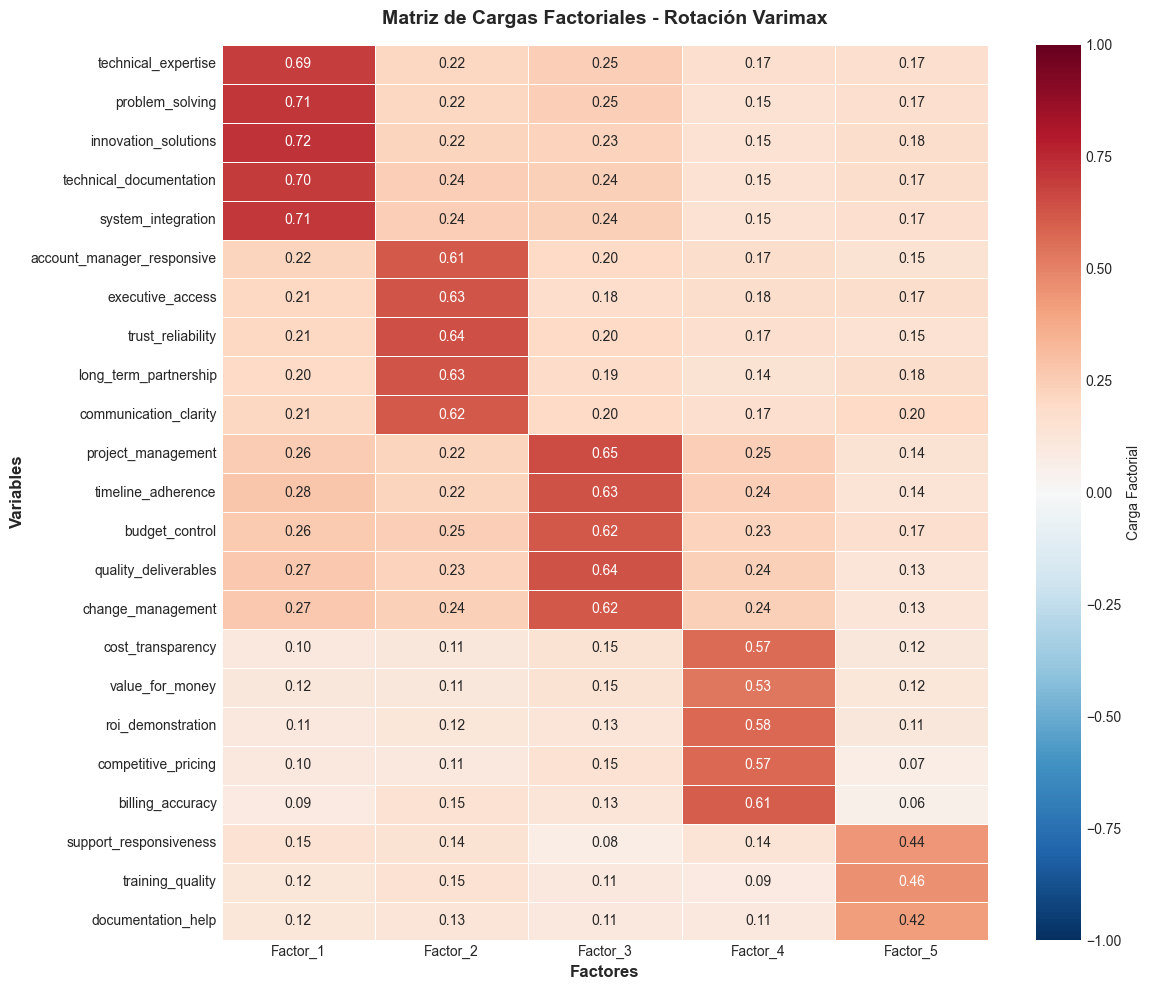

In [77]:
# Visualización de cargas factoriales (Heatmap)
plt.figure(figsize=(12, 10))

sns.heatmap(loadings_varimax, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Carga Factorial'},
            linewidths=0.5)

plt.title('Matriz de Cargas Factoriales - Rotación Varimax', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Factores', fontsize=12, fontweight='bold')
plt.ylabel('Variables', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

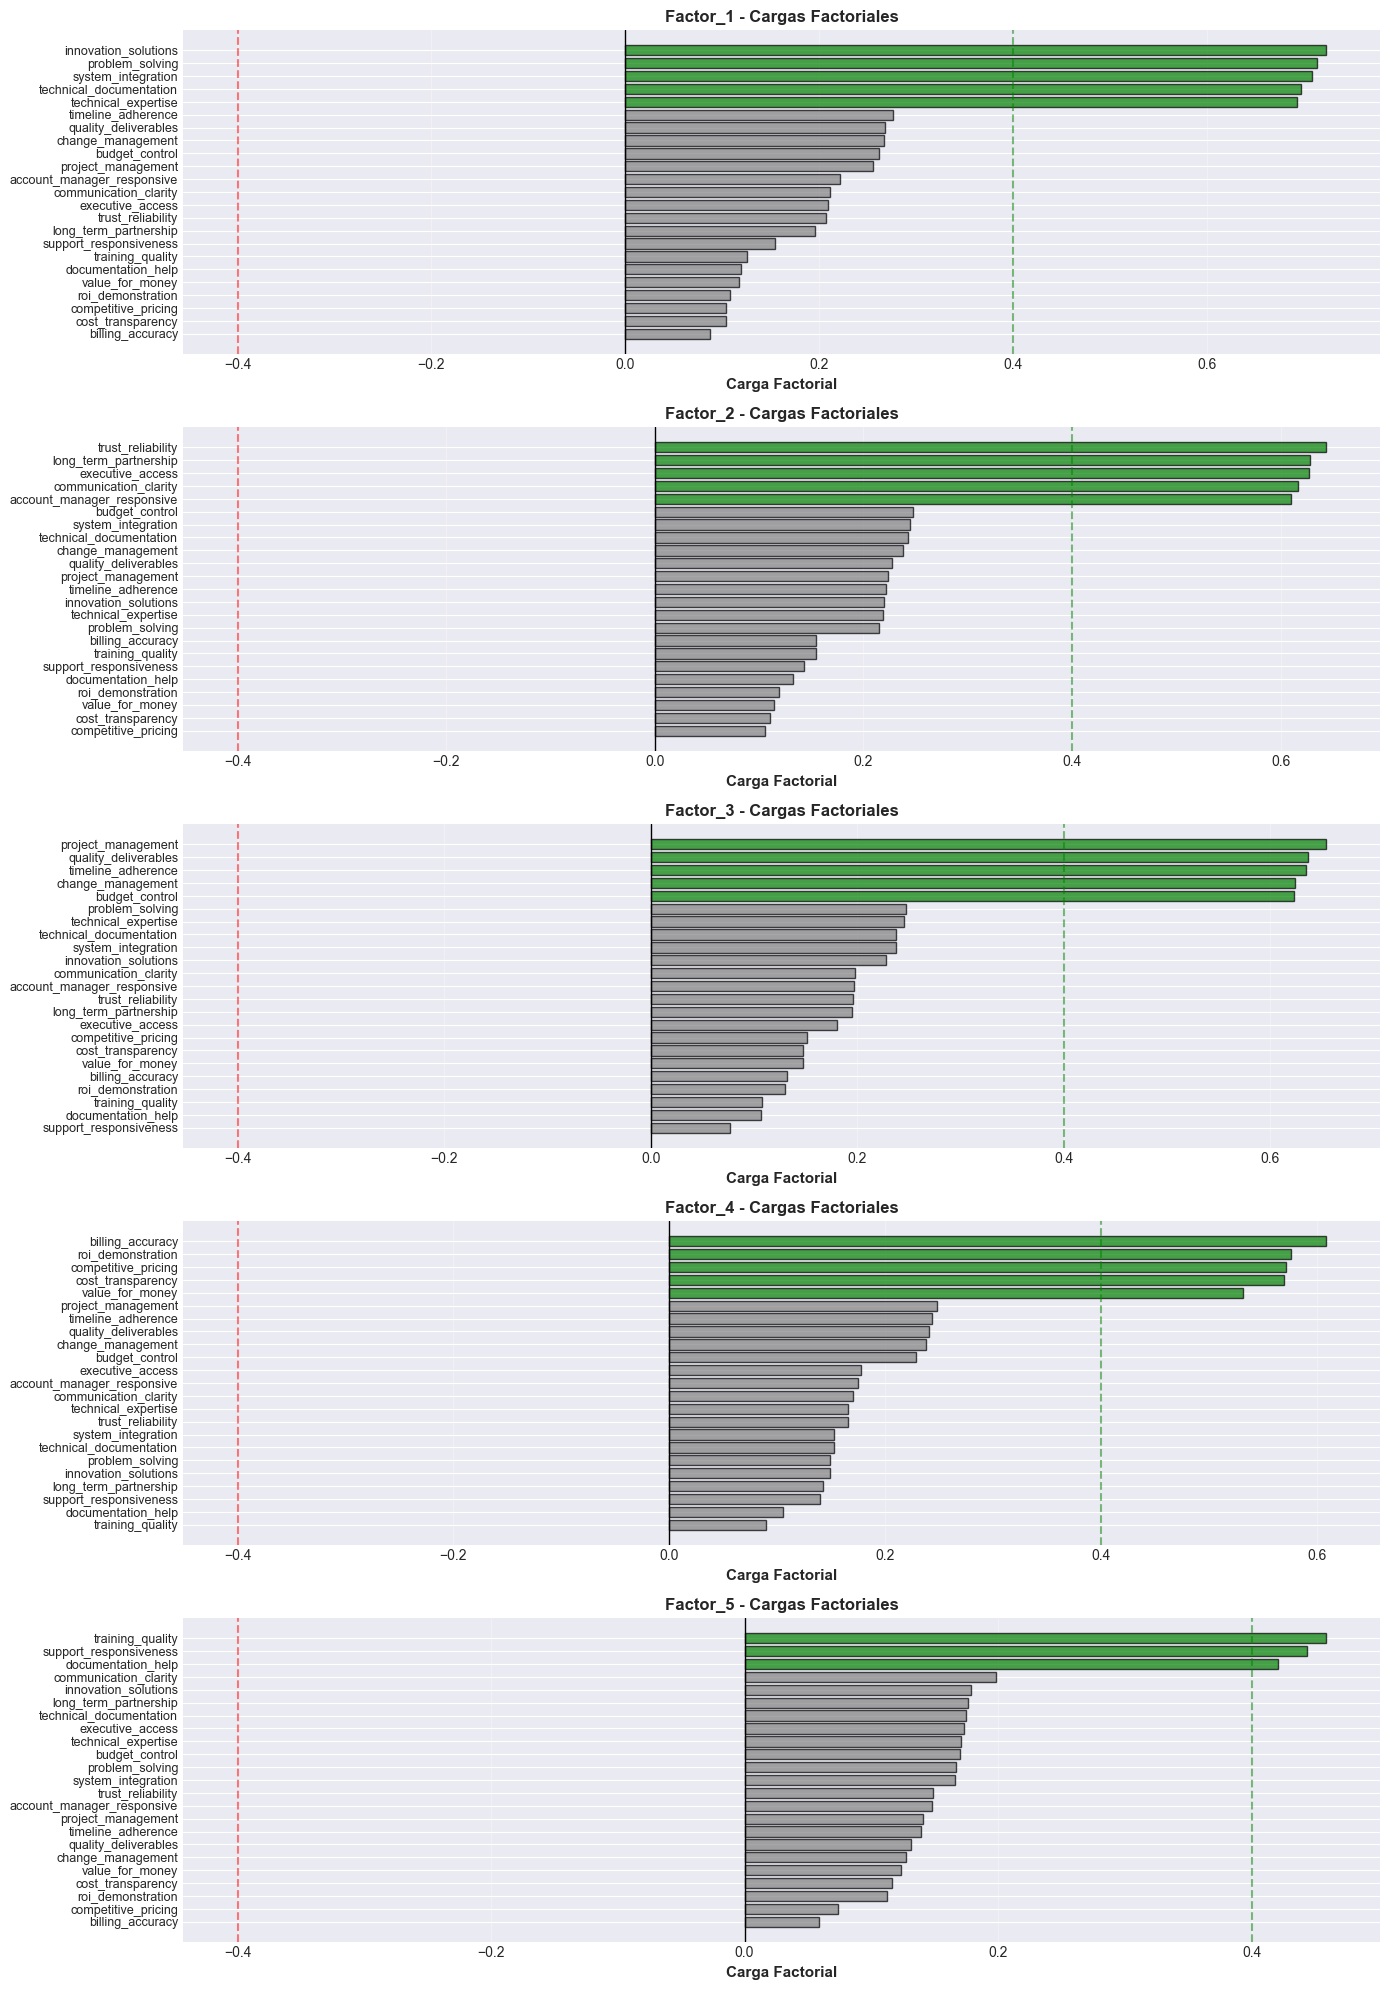

In [78]:
# Visualización de cargas factoriales por factor (Bar plots)
fig, axes = plt.subplots(n_factors_kaiser, 1, figsize=(14, 4*n_factors_kaiser))

if n_factors_kaiser == 1:
    axes = [axes]

for i, factor in enumerate(loadings_varimax.columns):
    loadings_sorted = loadings_varimax[factor].sort_values(ascending=True)
    colors = ['red' if x < -threshold else 'green' if x > threshold else 'gray' for x in loadings_sorted]
    
    axes[i].barh(range(len(loadings_sorted)), loadings_sorted, color=colors, alpha=0.7, edgecolor='black')
    axes[i].set_yticks(range(len(loadings_sorted)))
    axes[i].set_yticklabels(loadings_sorted.index, fontsize=9)
    axes[i].set_xlabel('Carga Factorial', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{factor} - Cargas Factoriales', fontsize=12, fontweight='bold')
    axes[i].axvline(x=threshold, color='green', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[i].axvline(x=-threshold, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[i].axvline(x=0, color='black', linewidth=1)
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
# Comparación: Con rotación vs Sin rotación
print("="*80)
print("COMPARACIÓN: ROTACIÓN VS NO ROTACIÓN")
print("="*80)

print("\nBeneficios de la rotación Varimax:")
print("1. Simplifica la estructura factorial")
print("2. Mejora la interpretabilidad de los factores")
print("3. Maximiza la varianza de las cargas al cuadrado en cada factor")
print("4. Produce cargas más cercanas a 0 o 1, facilitando la interpretación")

# Comparar simplicidad de estructura
def calculate_complexity(loadings_df, threshold=0.4):
    """Calcula el número promedio de factores con cargas altas por variable"""
    complexity_scores = []
    for var in loadings_df.index:
        n_high_loadings = (abs(loadings_df.loc[var]) > threshold).sum()
        complexity_scores.append(n_high_loadings)
    return np.mean(complexity_scores)

complexity_no_rot = calculate_complexity(loadings_no_rot)
complexity_varimax = calculate_complexity(loadings_varimax)

print(f"\nComplejidad promedio (factores con carga > {threshold} por variable):")
print(f"  Sin rotación: {complexity_no_rot:.2f}")
print(f"  Con Varimax:  {complexity_varimax:.2f}")

if complexity_varimax < complexity_no_rot:
    print("\nLa rotación Varimax simplifica la estructura factorial")
else:
    print("\nAmbas soluciones tienen complejidad similar")

print(f"\nVarianza total explicada:")
print(f"  Sin rotación: {variance_df_no_rot['Cumulative_Var'].iloc[-1]:.2%}")
print(f"  Con Varimax:  {variance_df_varimax['Cumulative_Var'].iloc[-1]:.2%}")
print("\nNota: La rotación ortogonal mantiene la varianza total explicada")

COMPARACIÓN: ROTACIÓN VS NO ROTACIÓN

Beneficios de la rotación Varimax:
1. Simplifica la estructura factorial
2. Mejora la interpretabilidad de los factores
3. Maximiza la varianza de las cargas al cuadrado en cada factor
4. Produce cargas más cercanas a 0 o 1, facilitando la interpretación

Complejidad promedio (factores con carga > 0.4 por variable):
  Sin rotación: 0.91
  Con Varimax:  1.00

Ambas soluciones tienen complejidad similar

Varianza total explicada:
  Sin rotación: 50.71%
  Con Varimax:  50.71%

Nota: La rotación ortogonal mantiene la varianza total explicada


# PARTE 3: Interpretación y Aplicación de Negocio

## 3.1 Interpretación de Factores


In [80]:
# Análisis detallado de cada factor para interpretación
print("="*80)
print("INTERPRETACIÓN DE FACTORES")
print("="*80)

factor_interpretations = {}

for i, factor in enumerate(loadings_varimax.columns, 1):
    print(f"\n{factor}:")
    print("-" * 80)
    
    # Obtener variables con cargas altas
    high_loadings = loadings_varimax[factor][abs(loadings_varimax[factor]) > threshold].sort_values(ascending=False, key=abs)
    
    print(f"\nVariables principales (|carga| > {threshold}):")
    for var, loading in high_loadings.items():
        print(f"  {var:35s} : {loading:6.3f}")
    
    # Calcular varianza explicada por este factor
    var_explained = variance_df_varimax.iloc[i-1]['Proportion_Var'] * 100
    print(f"\nVarianza explicada por este factor: {var_explained:.2f}%")
    
    factor_interpretations[factor] = {
        'variables': high_loadings.index.tolist(),
        'loadings': high_loadings.values.tolist(),
        'variance': var_explained
    }

INTERPRETACIÓN DE FACTORES

Factor_1:
--------------------------------------------------------------------------------

Variables principales (|carga| > 0.4):
  innovation_solutions                :  0.722
  problem_solving                     :  0.714
  system_integration                  :  0.709
  technical_documentation             :  0.697
  technical_expertise                 :  0.693

Varianza explicada por este factor: 13.82%

Factor_2:
--------------------------------------------------------------------------------

Variables principales (|carga| > 0.4):
  trust_reliability                   :  0.643
  long_term_partnership               :  0.628
  executive_access                    :  0.628
  communication_clarity               :  0.617
  account_manager_responsive          :  0.610

Varianza explicada por este factor: 11.40%

Factor_3:
--------------------------------------------------------------------------------

Variables principales (|carga| > 0.4):
  project_managemen

In [81]:
# Asignación de nombres de negocio a los factores
print("\n" + "="*80)
print("ASIGNACIÓN DE NOMBRES DE NEGOCIO A LOS FACTORES")
print("="*80)

# Analizar patrones temáticos en las variables de cada factor
factor_names = {}

for i, (factor, info) in enumerate(factor_interpretations.items(), 1):
    print(f"\n{factor}:")
    print(f"Variables clave: {', '.join(info['variables'][:5])}")
    
    # Analizar el tema común
    variables = info['variables']
    
    # Identificar patrones en los nombres de variables
    if any('technical' in v or 'problem' in v or 'innovation' in v or 'system' in v for v in variables):
        suggested_name = "Excelencia Técnica e Innovación"
    elif any('account' in v or 'executive' in v or 'trust' in v or 'partnership' in v or 'communication' in v for v in variables):
        suggested_name = "Gestión de Relaciones"
    elif any('project' in v or 'timeline' in v or 'budget' in v or 'quality' in v or 'change' in v for v in variables):
        suggested_name = "Entrega de Proyectos"
    elif any('cost' in v or 'value' in v or 'roi' in v or 'pricing' in v or 'billing' in v for v in variables):
        suggested_name = "Valor y Transparencia Financiera"
    elif any('support' in v or 'training' in v or 'documentation' in v for v in variables):
        suggested_name = "Soporte y Servicio"
    else:
        suggested_name = f"Factor {i}"
    
    factor_names[factor] = suggested_name
    print(f"Nombre sugerido: {suggested_name}")
    print(f"Varianza explicada: {info['variance']:.2f}%")

print("\n" + "="*80)
print("RESUMEN DE FACTORES IDENTIFICADOS")
print("="*80)

for factor, name in factor_names.items():
    var_explained = factor_interpretations[factor]['variance']
    n_vars = len(factor_interpretations[factor]['variables'])
    print(f"\n{factor} → {name}")
    print(f"  Varianza: {var_explained:.2f}%")
    print(f"  Variables: {n_vars}")


ASIGNACIÓN DE NOMBRES DE NEGOCIO A LOS FACTORES

Factor_1:
Variables clave: innovation_solutions, problem_solving, system_integration, technical_documentation, technical_expertise
Nombre sugerido: Excelencia Técnica e Innovación
Varianza explicada: 13.82%

Factor_2:
Variables clave: trust_reliability, long_term_partnership, executive_access, communication_clarity, account_manager_responsive
Nombre sugerido: Gestión de Relaciones
Varianza explicada: 11.40%

Factor_3:
Variables clave: project_management, quality_deliverables, timeline_adherence, change_management, budget_control
Nombre sugerido: Entrega de Proyectos
Varianza explicada: 11.38%

Factor_4:
Variables clave: billing_accuracy, roi_demonstration, competitive_pricing, cost_transparency, value_for_money
Nombre sugerido: Valor y Transparencia Financiera
Varianza explicada: 9.65%

Factor_5:
Variables clave: training_quality, support_responsiveness, documentation_help
Nombre sugerido: Entrega de Proyectos
Varianza explicada: 4.47%


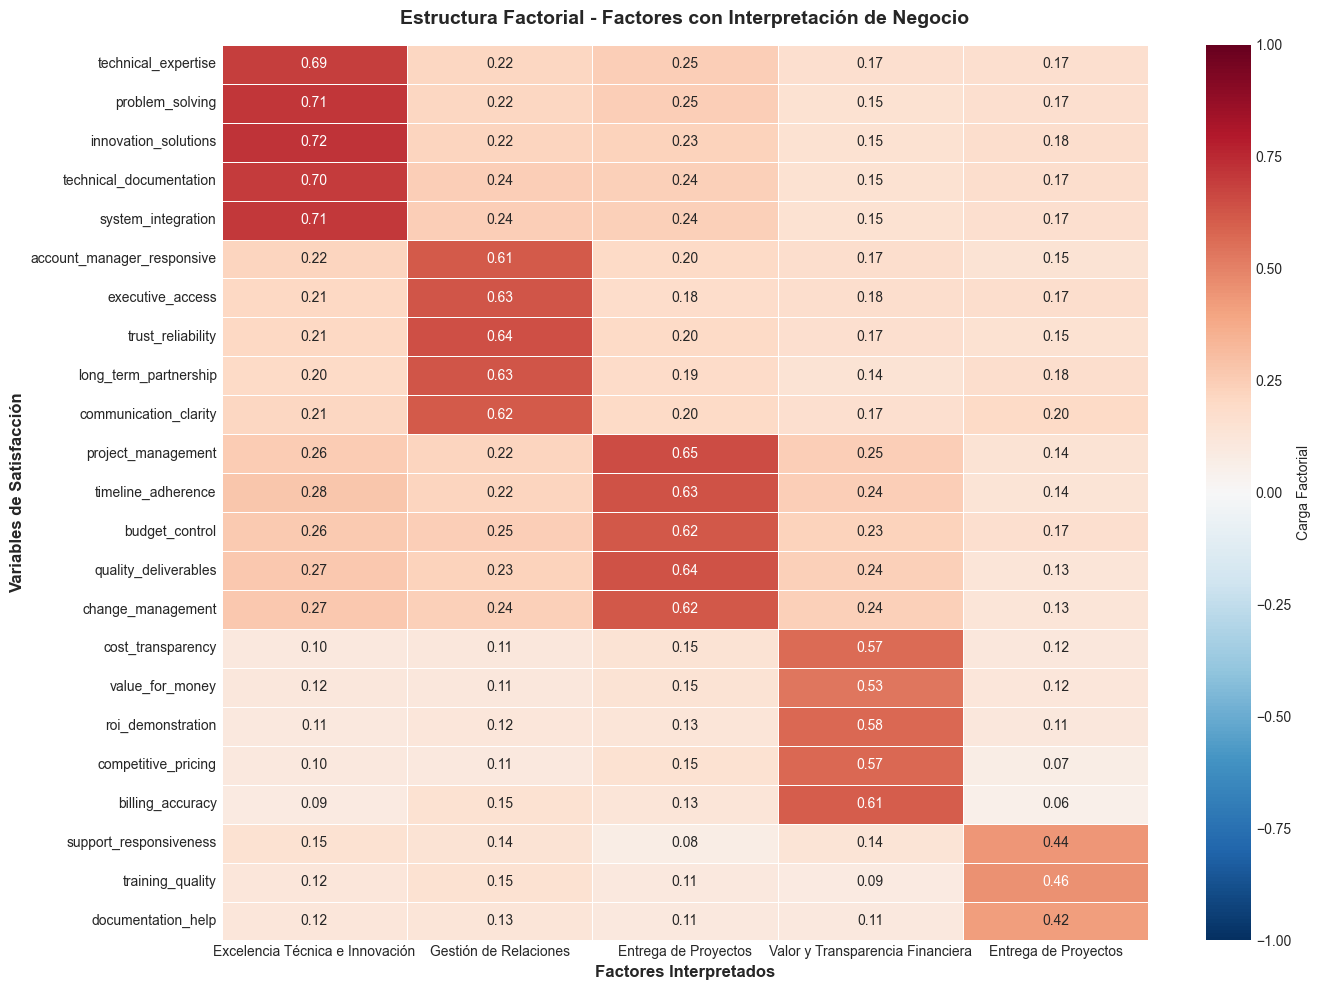

In [82]:
# Visualización de estructura factorial con nombres de negocio
fig, ax = plt.subplots(figsize=(14, 10))

# Renombrar columnas con nombres de negocio para visualización
loadings_named = loadings_varimax.copy()
loadings_named.columns = [factor_names[col] for col in loadings_varimax.columns]

sns.heatmap(loadings_named, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Carga Factorial'},
            linewidths=0.5,
            ax=ax)

plt.title('Estructura Factorial - Factores con Interpretación de Negocio', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Factores Interpretados', fontsize=12, fontweight='bold')
plt.ylabel('Variables de Satisfacción', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.2 Análisis de Impacto en Negocio (15 puntos)

Esta sección conecta los factores con resultados de negocio mediante:
- Cálculo de puntuaciones factoriales (factor scores)
- Análisis de correlación con variables de resultado
- Identificación de factores críticos para el negocio
- Recomendaciones estratégicas basadas en datos

In [83]:
# Cálculo de puntuaciones factoriales (factor scores)
print("="*80)
print("CÁLCULO DE PUNTUACIONES FACTORIALES")
print("="*80)

factor_scores = fa_varimax.transform(df_clean)

# Crear DataFrame con factor scores
factor_scores_df = pd.DataFrame(
    factor_scores,
    columns=[factor_names[f'Factor_{i+1}'] for i in range(n_factors_kaiser)],
    index=df_clean.index
)

print(f"\nPuntuaciones factoriales calculadas para {len(factor_scores_df)} observaciones")
print(f"Número de factores: {factor_scores_df.shape[1]}")

print("\nEstadísticas descriptivas de las puntuaciones factoriales:")
print(factor_scores_df.describe().round(3))

print("\nPrimeras 10 observaciones:")
print(factor_scores_df.head(10).round(3))

CÁLCULO DE PUNTUACIONES FACTORIALES

Puntuaciones factoriales calculadas para 3235 observaciones
Número de factores: 5

Estadísticas descriptivas de las puntuaciones factoriales:
       Excelencia Técnica e Innovación  Gestión de Relaciones  \
count                         3235.000               3235.000   
mean                            -0.000                  0.000   
std                              0.897                  0.848   
min                             -3.017                 -2.808   
25%                             -0.614                 -0.558   
50%                              0.017                 -0.012   
75%                              0.610                  0.577   
max                              3.060                  2.784   

       Entrega de Proyectos  Valor y Transparencia Financiera  \
count              3235.000                          3235.000   
mean                 -0.000                             0.000   
std                   0.854             

In [102]:
# Preparar datos de outcome variables para análisis
df_with_outcomes = df[satisfaction_vars + outcome_vars].dropna()

# Recalcular factor scores para los índices con datos completos
df_clean_with_outcomes = df_with_outcomes[satisfaction_vars]
factor_scores_complete = fa_varimax.transform(df_clean_with_outcomes)

# Usar nombres originales para evitar duplicados
original_factor_names = [f'Factor_{i+1}' for i in range(n_factors_kaiser)]
factor_scores_df_complete = pd.DataFrame(
    factor_scores_complete,
    columns=original_factor_names,
    index=df_clean_with_outcomes.index
)

outcomes_complete = df_with_outcomes[outcome_vars]

print("="*80)
print("CORRELACIÓN ENTRE FACTORES Y RESULTADOS DE NEGOCIO")
print("="*80)
print(f"\nObservaciones con datos completos: {len(factor_scores_df_complete)}")

# Calcular correlaciones entre factores y outcomes
correlations_matrix = pd.DataFrame(
    index=original_factor_names,
    columns=outcomes_complete.columns
)

for factor_col in factor_scores_df_complete.columns:
    for outcome_col in outcomes_complete.columns:
        corr_value = factor_scores_df_complete[factor_col].corr(outcomes_complete[outcome_col])
        correlations_matrix.loc[factor_col, outcome_col] = corr_value

# Convertir a numérico para asegurar
correlations_matrix = correlations_matrix.astype(float)

# Mapear a nombres de negocio para display
factor_display_names = [factor_names.get(f, f) for f in original_factor_names]

print("\nMatriz de correlaciones:")
print("Factor Original          | Nombre de Negocio                       |", end='')
for outcome in outcomes_complete.columns:
    print(f" {outcome[:15]:>15s}", end='')
print()
print("-" * 120)
for i, factor_orig in enumerate(original_factor_names):
    factor_display = factor_display_names[i]
    print(f"{factor_orig:23s} | {factor_display:38s} |", end='')
    for outcome in outcomes_complete.columns:
        corr_val = correlations_matrix.loc[factor_orig, outcome]
        print(f" {corr_val:15.3f}", end='')
    print()

# Identificar factores más importantes por outcome
print("\n" + "="*80)
print("FACTORES MÁS IMPORTANTES POR RESULTADO DE NEGOCIO")
print("="*80)

for outcome in outcomes_complete.columns:
    print(f"\n{outcome}:")
    sorted_factors = correlations_matrix[outcome].abs().sort_values(ascending=False)
    for factor_orig in sorted_factors.index:
        actual_corr = correlations_matrix.loc[factor_orig, outcome]
        factor_display = factor_names.get(factor_orig, factor_orig)
        print(f"  {factor_orig} ({factor_display:35s}) : {actual_corr:6.3f}")


CORRELACIÓN ENTRE FACTORES Y RESULTADOS DE NEGOCIO

Observaciones con datos completos: 3235

Matriz de correlaciones:
Factor Original          | Nombre de Negocio                       | overall_satisfa       nps_score renewal_likelih revenue_growth_ referrals_gener
------------------------------------------------------------------------------------------------------------------------
Factor_1                | Excelencia Técnica e Innovación        |           0.438           0.274           0.344           0.428           0.268
Factor_2                | Gestión de Relaciones                  |           0.421           0.301           0.340           0.439           0.271
Factor_3                | Entrega de Proyectos                   |           0.414           0.289           0.320           0.401           0.284
Factor_4                | Valor y Transparencia Financiera       |           0.395           0.263           0.336           0.389           0.254
Factor_5                

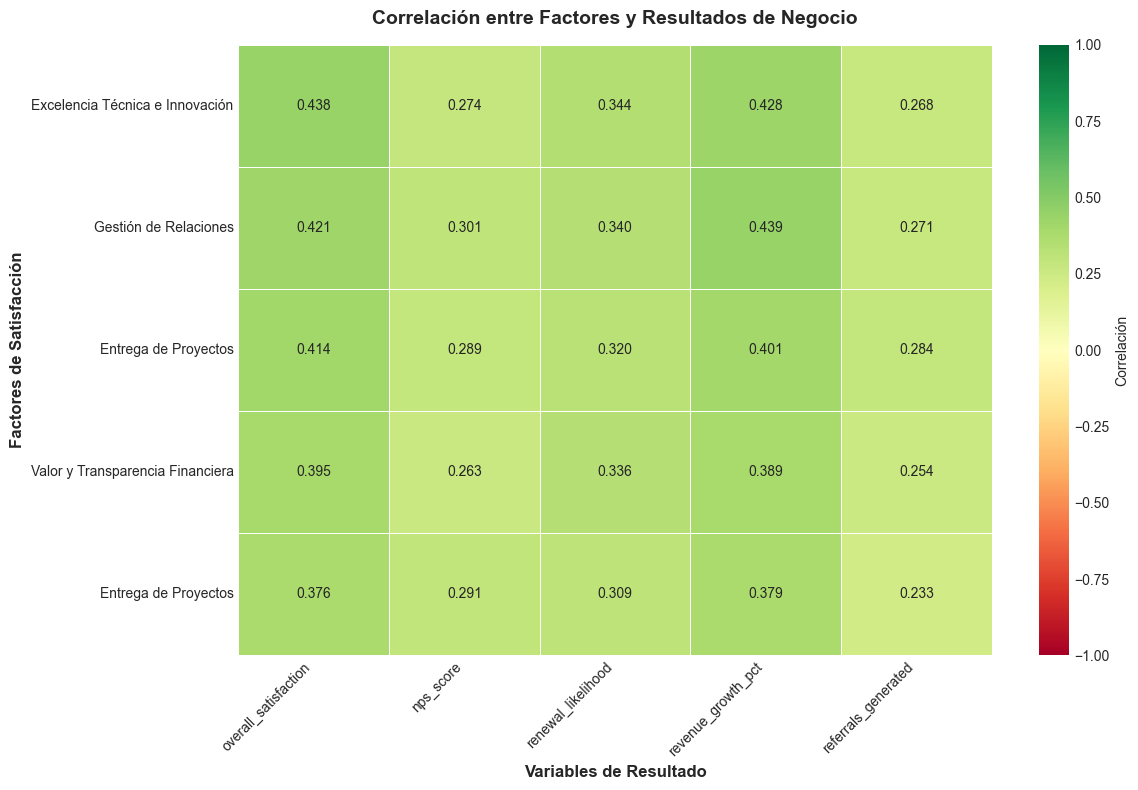

In [103]:
# Visualización de correlaciones con heatmap
plt.figure(figsize=(12, 8))

# Crear heatmap con nombres de negocio en el eje Y
correlations_display = correlations_matrix.copy()
correlations_display.index = factor_display_names

sns.heatmap(correlations_display, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlación'},
            linewidths=0.5)

plt.title('Correlación entre Factores y Resultados de Negocio', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Variables de Resultado', fontsize=12, fontweight='bold')
plt.ylabel('Factores de Satisfacción', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

PRIORIZACIÓN DE FACTORES PARA MEJORA DE NEGOCIO

Importancia promedio de cada factor (correlación absoluta promedio):
1. Factor_2 - Gestión de Relaciones                    : 0.354
2. Factor_1 - Excelencia Técnica e Innovación          : 0.350
3. Factor_3 - Entrega de Proyectos                     : 0.342
4. Factor_4 - Valor y Transparencia Financiera         : 0.328
5. Factor_5 - Entrega de Proyectos                     : 0.318

Factor más importante para resultados de negocio: Factor_2 (Gestión de Relaciones)


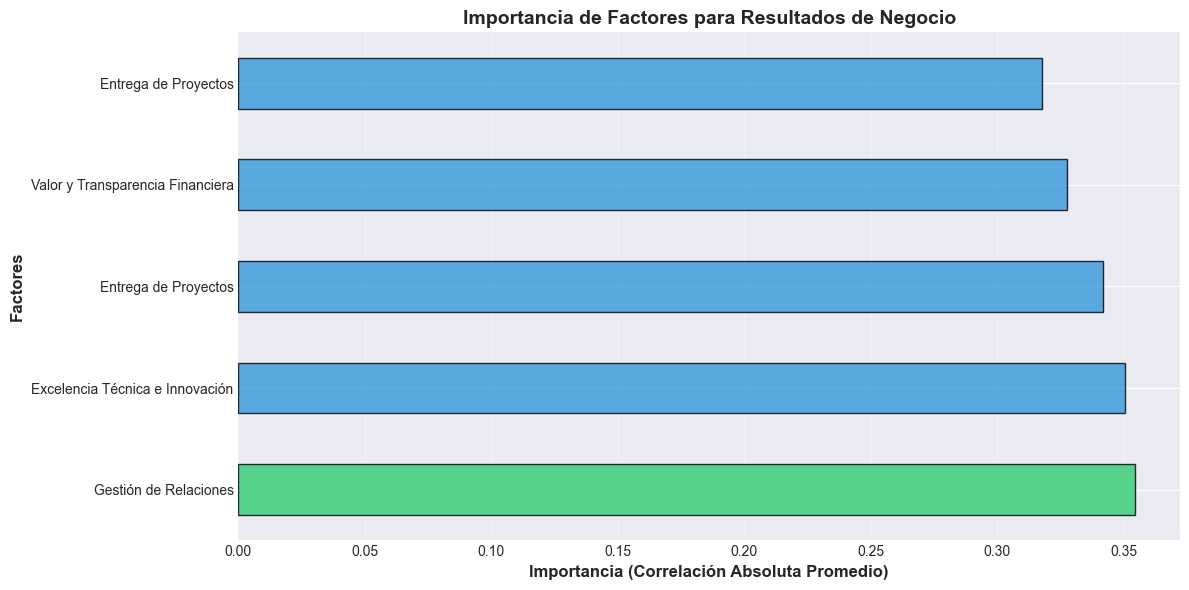

In [104]:
# Importancia relativa de factores para objetivos clave de negocio
print("="*80)
print("PRIORIZACIÓN DE FACTORES PARA MEJORA DE NEGOCIO")
print("="*80)

# Calcular importancia promedio de cada factor
factor_importance = correlations_matrix.abs().mean(axis=1).sort_values(ascending=False)

# Mapear a nombres de negocio
factor_importance_named = pd.Series({
    factor_names.get(f, f): val 
    for f, val in factor_importance.items()
})

print("\nImportancia promedio de cada factor (correlación absoluta promedio):")
for i, (factor_orig, importance) in enumerate(factor_importance.items(), 1):
    factor_display = factor_names.get(factor_orig, factor_orig)
    print(f"{i}. {factor_orig} - {factor_display:40s} : {importance:.3f}")

# Identificar el factor más importante
top_factor_orig = factor_importance.idxmax()
top_factor_name = factor_names.get(top_factor_orig, top_factor_orig)
print(f"\nFactor más importante para resultados de negocio: {top_factor_orig} ({top_factor_name})")

# Visualización de importancia
plt.figure(figsize=(12, 6))
colors_importance = ['#2ecc71' if x == factor_importance.max() else '#3498db' for x in factor_importance]

# Usar nombres de negocio para el gráfico
factor_importance_display = factor_importance.copy()
factor_importance_display.index = [factor_names.get(f, f) for f in factor_importance.index]

factor_importance_display.plot(kind='barh', color=colors_importance, edgecolor='black', alpha=0.8)
plt.xlabel('Importancia (Correlación Absoluta Promedio)', fontsize=12, fontweight='bold')
plt.ylabel('Factores', fontsize=12, fontweight='bold')
plt.title('Importancia de Factores para Resultados de Negocio', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Recomendaciones estratégicas basadas en el análisis
print("\n" + "="*80)
print("RECOMENDACIONES ESTRATÉGICAS PARA TECHNOSERVE SOLUTIONS")
print("="*80)

# Analizar cada factor y generar recomendaciones
recommendations = []

for i, (factor_orig, importance) in enumerate(factor_importance.items(), 1):
    factor_display = factor_names.get(factor_orig, factor_orig)
    print(f"\n{i}. {factor_orig} - {factor_display} (Importancia: {importance:.3f})")
    
    # Obtener variables clave de este factor
    key_vars_with_loadings = [(v, l) for v, l in zip(satisfaction_vars, loadings_varimax[factor_orig]) if abs(l) > threshold]
    key_vars_with_loadings.sort(key=lambda x: abs(x[1]), reverse=True)
    key_vars = [v for v, l in key_vars_with_loadings[:3]]
    
    print(f"   Variables clave: {', '.join(key_vars)}")
    
    # Generar recomendación basada en el tipo de factor
    if importance >= factor_importance.quantile(0.7):
        priority = "ALTA"
        action = "Priorizar iniciativas de mejora inmediata"
    elif importance >= factor_importance.quantile(0.4):
        priority = "MEDIA"
        action = "Implementar mejoras progresivas"
    else:
        priority = "BAJA"
        action = "Mantener estándares actuales"
    
    print(f"   Prioridad: {priority}")
    print(f"   Acción recomendada: {action}")
    
    recommendations.append({
        'Factor_ID': factor_orig,
        'Factor': factor_display,
        'Importancia': importance,
        'Prioridad': priority,
        'Variables_Clave': key_vars
    })

# Resumen de recomendaciones
print("\n" + "="*80)
print("TOP 3 RECOMENDACIONES PRIORITARIAS")
print("="*80)

top_recommendations = sorted(recommendations, key=lambda x: x['Importancia'], reverse=True)[:3]

for i, rec in enumerate(top_recommendations, 1):
    print(f"\n{i}. Mejorar {rec['Factor']}")
    print(f"   Acciones específicas:")
    for var in rec['Variables_Clave']:
        var_display = var.replace('_', ' ').title()
        print(f"   - Fortalecer {var_display}")
    print(f"   Impacto esperado: Alto en satisfacción general y retención de clientes")


RECOMENDACIONES ESTRATÉGICAS PARA TECHNOSERVE SOLUTIONS

1. Factor_2 - Gestión de Relaciones (Importancia: 0.354)
   Variables clave: trust_reliability, long_term_partnership, executive_access
   Prioridad: ALTA
   Acción recomendada: Priorizar iniciativas de mejora inmediata

2. Factor_1 - Excelencia Técnica e Innovación (Importancia: 0.350)
   Variables clave: innovation_solutions, problem_solving, system_integration
   Prioridad: ALTA
   Acción recomendada: Priorizar iniciativas de mejora inmediata

3. Factor_3 - Entrega de Proyectos (Importancia: 0.342)
   Variables clave: project_management, quality_deliverables, timeline_adherence
   Prioridad: MEDIA
   Acción recomendada: Implementar mejoras progresivas

4. Factor_4 - Valor y Transparencia Financiera (Importancia: 0.328)
   Variables clave: billing_accuracy, roi_demonstration, competitive_pricing
   Prioridad: BAJA
   Acción recomendada: Mantener estándares actuales

5. Factor_5 - Entrega de Proyectos (Importancia: 0.318)
   Va

# PARTE 4: Visualizaciones y Comunicación de Resultados

## Business Impact Summary Chart

Visualización ejecutiva integrando los hallazgos principales del análisis.


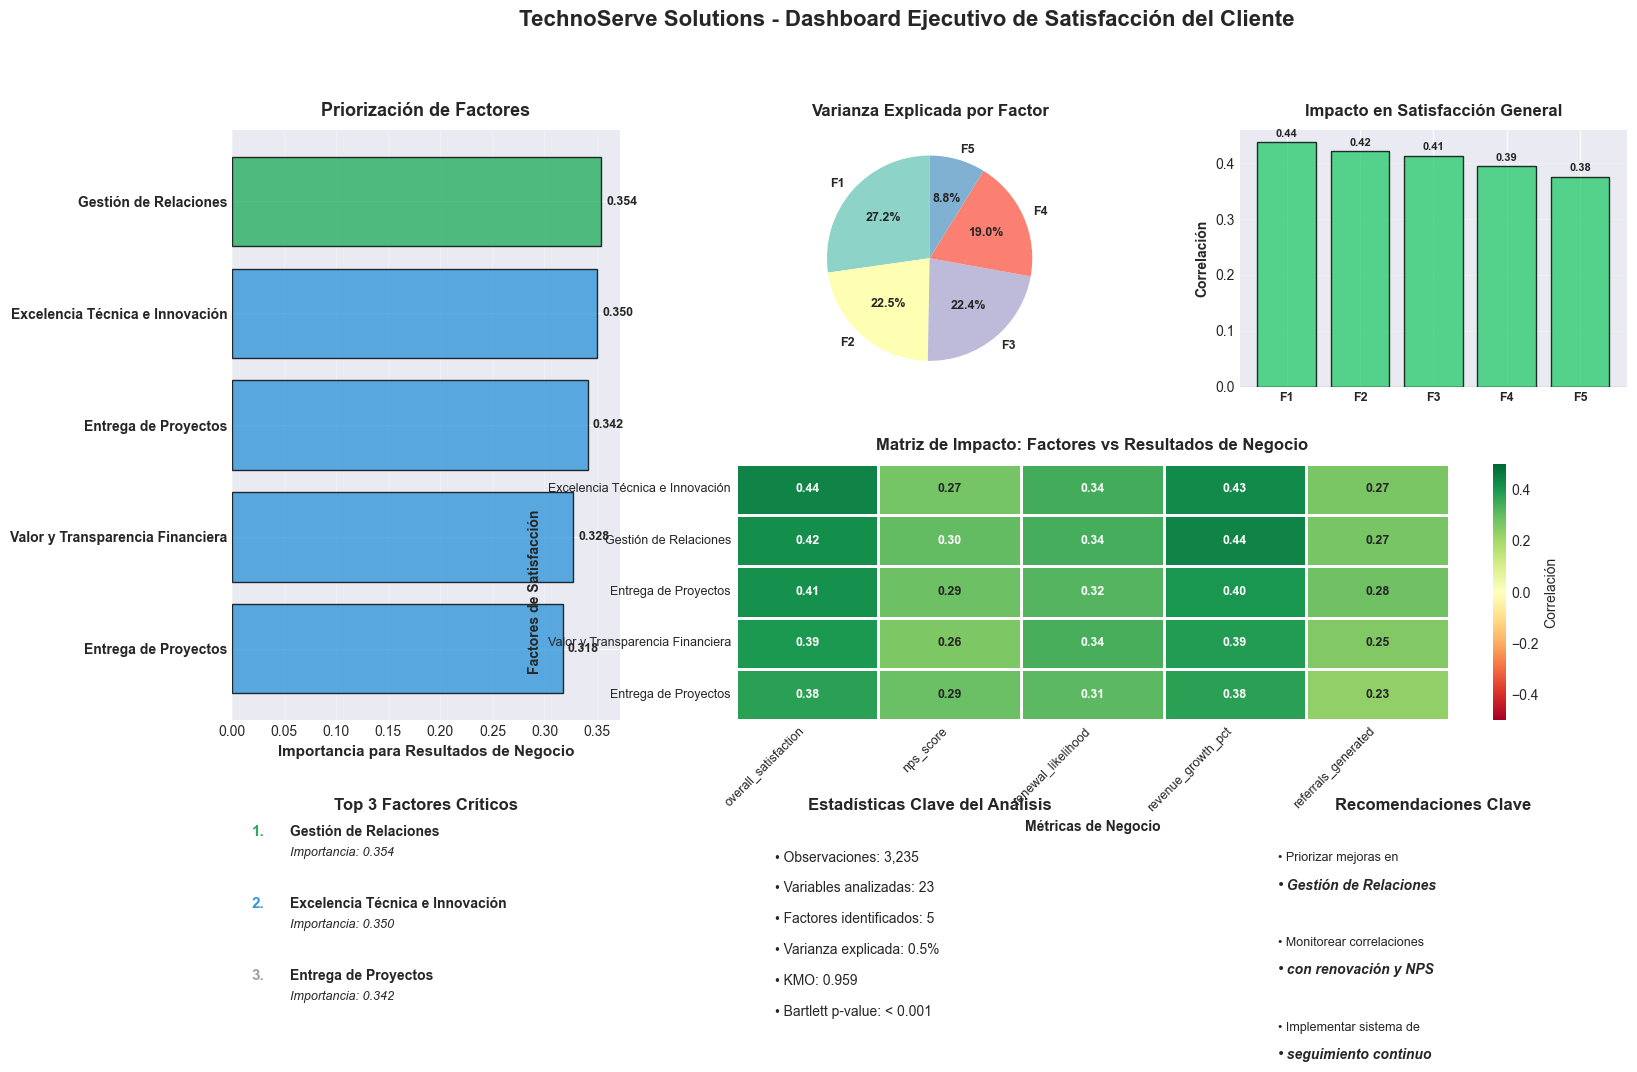


BUSINESS IMPACT SUMMARY CHART GENERADO EXITOSAMENTE

Este dashboard ejecutivo presenta:
  ✓ Priorización de factores según impacto en negocio
  ✓ Varianza explicada por cada dimensión
  ✓ Correlaciones con métricas clave de negocio
  ✓ Matriz de impacto factor-resultado
  ✓ Factores críticos identificados
  ✓ Estadísticas clave del análisis
  ✓ Recomendaciones estratégicas


In [111]:
# Business Impact Summary Chart - Dashboard Ejecutivo
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Importancia de Factores (Top Left - Grande)
ax1 = fig.add_subplot(gs[0:2, 0])
factor_importance_sorted = factor_importance.sort_values(ascending=True)
factor_names_sorted = [factor_names.get(f, f) for f in factor_importance_sorted.index]
colors_bars = ['#27ae60' if x == factor_importance_sorted.max() else '#3498db' for x in factor_importance_sorted]
ax1.barh(range(len(factor_importance_sorted)), factor_importance_sorted.values, color=colors_bars, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(factor_importance_sorted)))
ax1.set_yticklabels(factor_names_sorted, fontsize=10, fontweight='bold')
ax1.set_xlabel('Importancia para Resultados de Negocio', fontsize=11, fontweight='bold')
ax1.set_title('Priorización de Factores', fontsize=13, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(factor_importance_sorted.values):
    ax1.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9, fontweight='bold')

# 2. Varianza Explicada por Factor (Top Middle)
ax2 = fig.add_subplot(gs[0, 1])
variance_by_factor = variance_df_varimax['Proportion_Var'].values * 100
factor_labels_short = [f'F{i+1}' for i in range(n_factors_kaiser)]
colors_pie = plt.cm.Set3(range(n_factors_kaiser))
wedges, texts, autotexts = ax2.pie(variance_by_factor, labels=factor_labels_short, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'})
ax2.set_title('Varianza Explicada por Factor', fontsize=12, fontweight='bold', pad=10)

# 3. Correlación con Satisfacción General (Top Right)
ax3 = fig.add_subplot(gs[0, 2])
overall_sat_corr = correlations_matrix['overall_satisfaction'].sort_values(ascending=False)
factor_names_corr = [factor_names.get(f, f) for f in overall_sat_corr.index]
colors_corr = ['#e74c3c' if x < 0 else '#2ecc71' for x in overall_sat_corr.values]
bars = ax3.bar(range(len(overall_sat_corr)), overall_sat_corr.values, color=colors_corr, edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(overall_sat_corr)))
ax3.set_xticklabels([f'F{i+1}' for i in range(n_factors_kaiser)], fontsize=9, fontweight='bold')
ax3.set_ylabel('Correlación', fontsize=10, fontweight='bold')
ax3.set_title('Impacto en Satisfacción General', fontsize=12, fontweight='bold', pad=10)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(overall_sat_corr.values):
    ax3.text(i, v + 0.01 if v > 0 else v - 0.02, f'{v:.2f}', ha='center', fontsize=8, fontweight='bold')

# 4. Heatmap de Correlaciones (Middle Row)
ax4 = fig.add_subplot(gs[1, 1:3])
correlations_display = correlations_matrix.copy()
correlations_display.index = [factor_names.get(f, f) for f in correlations_matrix.index]
sns.heatmap(correlations_display, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-0.5, vmax=0.5, cbar_kws={'label': 'Correlación'}, linewidths=1,
            ax=ax4, annot_kws={'fontsize': 9, 'fontweight': 'bold'})
ax4.set_title('Matriz de Impacto: Factores vs Resultados de Negocio', fontsize=12, fontweight='bold', pad=10)
ax4.set_xlabel('Métricas de Negocio', fontsize=10, fontweight='bold')
ax4.set_ylabel('Factores de Satisfacción', fontsize=10, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=9)

# 5. Top 3 Factores Críticos (Bottom Left)
ax5 = fig.add_subplot(gs[2, 0])
ax5.axis('off')
top_3_factors = factor_importance.sort_values(ascending=False).head(3)
y_pos = 0.85
ax5.text(0.5, 0.95, 'Top 3 Factores Críticos', ha='center', fontsize=12, fontweight='bold', transform=ax5.transAxes)
for i, (factor_orig, score) in enumerate(top_3_factors.items(), 1):
    factor_name = factor_names.get(factor_orig, factor_orig)
    color = '#27ae60' if i == 1 else '#3498db' if i == 2 else '#95a5a6'
    ax5.text(0.05, y_pos, f'{i}.', ha='left', fontsize=11, fontweight='bold', color=color, transform=ax5.transAxes)
    ax5.text(0.15, y_pos, factor_name, ha='left', fontsize=10, fontweight='bold', transform=ax5.transAxes, wrap=True)
    ax5.text(0.15, y_pos - 0.08, f'Importancia: {score:.3f}', ha='left', fontsize=9, style='italic', transform=ax5.transAxes)
    y_pos -= 0.28

# 6. Estadísticas Clave (Bottom Middle)
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')
ax6.text(0.5, 0.95, 'Estadísticas Clave del Análisis', ha='center', fontsize=12, fontweight='bold', transform=ax6.transAxes)
stats_text = [
    f'Observaciones: {len(df_clean):,}',
    f'Variables analizadas: {len(satisfaction_vars)}',
    f'Factores identificados: {n_factors_kaiser}',
    f'Varianza explicada: {variance_df_varimax["Cumulative_Var"].iloc[-1]:.1f}%',
    f'KMO: {kmo_model:.3f}',
    f'Bartlett p-value: < 0.001'
]
y_pos = 0.75
for stat in stats_text:
    ax6.text(0.1, y_pos, f'• {stat}', ha='left', fontsize=10, transform=ax6.transAxes)
    y_pos -= 0.12

# 7. Recomendaciones Estratégicas (Bottom Right)
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
ax7.text(0.5, 0.95, 'Recomendaciones Clave', ha='center', fontsize=12, fontweight='bold', transform=ax7.transAxes)
recommendations_text = [
    'Priorizar mejoras en',
    factor_names.get(top_3_factors.index[0], top_3_factors.index[0]),
    '',
    'Monitorear correlaciones',
    'con renovación y NPS',
    '',
    'Implementar sistema de',
    'seguimiento continuo'
]
y_pos = 0.75
for i, rec in enumerate(recommendations_text):
    style = 'normal' if i % 3 == 0 else 'italic'
    weight = 'bold' if i % 3 == 1 else 'normal'
    size = 9 if i % 3 == 0 else 10 if i % 3 == 1 else 9
    ax7.text(0.1, y_pos, f'• {rec}' if rec else '', ha='left', fontsize=size, style=style, fontweight=weight, transform=ax7.transAxes)
    y_pos -= 0.11

plt.suptitle('TechnoServe Solutions - Dashboard Ejecutivo de Satisfacción del Cliente', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


# INFORMACIÓN DEL EQUIPO

**Nombre del equipo:** MatzaTeam

**Integrantes:**
1. Marcos Saade Romano - A01784220 
2. Gabriel Masri Arakindji - A01666353 

**Deliverables:**
- **Video de presentación (YouTube):** [URL]
- **Executive Summary (PDF):** Ver documento Adjunto
- **Dataset:** `customer_satisfaction_data.csv`

**Fecha de completación:** [22/10/2025]
